### Цель: создание модели, которая будет предсказывать стоимость автомобиля по его характеристикам.

# 1. Разведовательный анализ (EDA) для тестового датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import seaborn as sns 

import plotly
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import plotly.offline as pyo
from plotly.offline import init_notebook_mode,plot,iplot

import folium

pyo.init_notebook_mode(connected=True)
cf.go_offline()

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# Установим параметры для изображений:
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

In [4]:
data = pd.read_csv('test.csv')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
data.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,0
1,седан,BMW,белый,дизель,2018.0,318d 2.0d AT (150 л.с.),4.0,2019.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,150 N12,Автомобиль из демонстрационного парка по спец ...,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,1
2,седан,BMW,синий,бензин,2009.0,550i xDrive 4.4 AT (407 л.с.) 4WD,4.0,2012.0,SEDAN AUTOMATIC 4.4,автоматическая,4.4 LTR,407 N12,Машина собиралась под заказ! \n\n,120000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,7 лет и 2 месяца,2
3,внедорожник 5 дв.,BMW,белый,дизель,2014.0,30d 3.0d AT (249 л.с.) 4WD,5.0,2015.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,249 N12,АВТОМОБИЛЬ В БЕЗУПРЕЧНОМ ВНЕШНЕМ И ТЕХНИЧЕСКОМ...,111466.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,NaN,3
4,внедорожник 5 дв.,BMW,синий,дизель,2014.0,M50d 3.0d AT (381 л.с.) 4WD,5.0,2019.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,381 N12,Автомобиль не имеет собственников ( физ. лиц) ...,11891.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,4


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              3837 non-null   object 
 1   brand                 3837 non-null   object 
 2   color                 3837 non-null   object 
 3   fuelType              3837 non-null   object 
 4   modelDate             3837 non-null   float64
 5   name                  3837 non-null   object 
 6   numberOfDoors         3837 non-null   float64
 7   productionDate        3837 non-null   float64
 8   vehicleConfiguration  3837 non-null   object 
 9   vehicleTransmission   3837 non-null   object 
 10  engineDisplacement    3837 non-null   object 
 11  enginePower           3837 non-null   object 
 12  description           3837 non-null   object 
 13  mileage               3837 non-null   float64
 14  Комплектация          3837 non-null   object 
 15  Привод               

In [8]:
def categorical_info(column_name, data, rotate=90, x_shift_mult=0, percentage=True):
    """Рисует распределение категориальных признаков и отображает их процентное содержание"""

    ax = sns.countplot(x=column_name,
                       data=data,
                       order=data[column_name].value_counts().index, orient="h")
    if percentage:
        total = len(data[column_name])
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + x_shift_mult*p.get_width()
            y = p.get_y() + p.get_height()+8
            ax.annotate(percentage, (x, y))
    plt.xticks(rotation=rotate)


def numeric_info(data, bins=10):
    """Печатает описательные статистики числового признака, а также рисует его распределение"""

    print(data.describe()[["min", "max", "25%", "50%", "75%", "std"]])
    sns.distplot(data, bins=bins)

## bodyType (тип кузова)

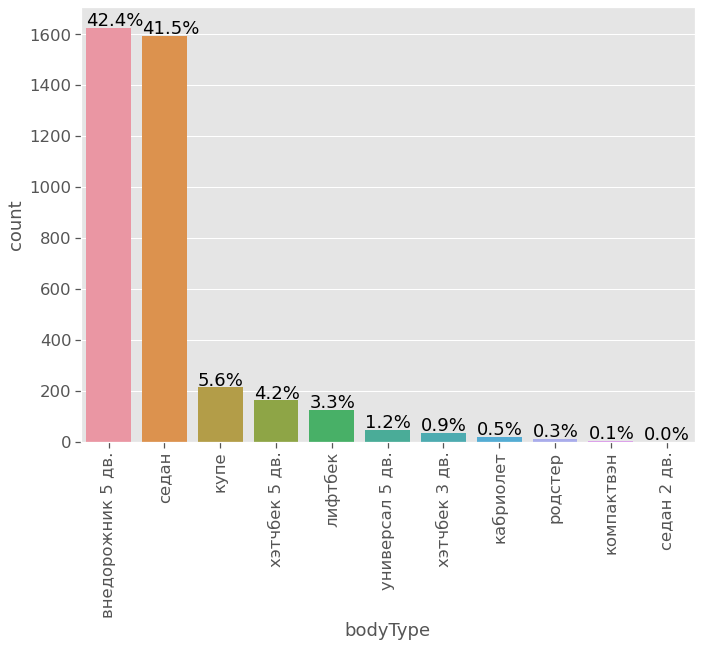

In [9]:
categorical_info("bodyType", data, rotate=90)

## brand (марка автомобиля)

In [10]:
print(
    f'Датасет представлен автомобилями марки {data.brand.unique()[0]}')

Датасет представлен автомобилями марки BMW


In [11]:
data.brand.unique()

array(['BMW'], dtype=object)

Исключим признак из расмотрения, так как он не информативен. Несмотря на это, мы получили ценную информацию для сбора данных в тренировочную выборку - это будут авто марки BMW

## color (цвет автомобиля)

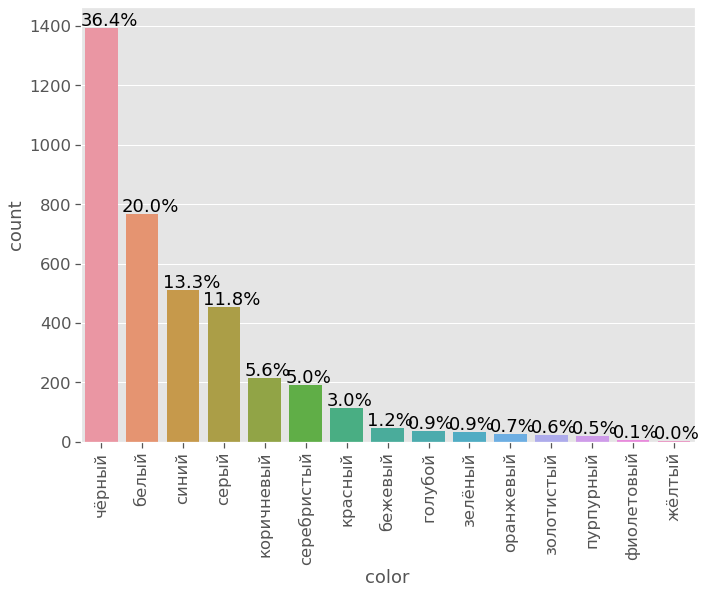

In [12]:
categorical_info("color", data, rotate=90, x_shift_mult=-1/8)

Всего в датасете представлено **15** различных цветов. Наиболее распространёнными цветами являются черный (36%), белый (20%), синий (13%) и серый (11%)

## fuelType (тип двигателя)

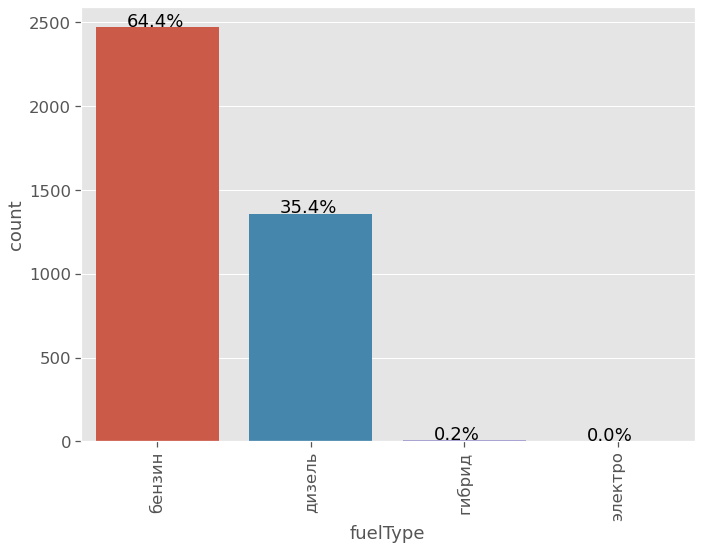

In [13]:
categorical_info("fuelType", data, rotate=90, x_shift_mult=1/4)

Датасет представлен четырьмя типами двигателей, наиболее распространённые типы - бензиновый (64%) и дизельный (35%)

## modelDate (год начала выпуска модели)

min    1975.000000
max    2019.000000
25%    2007.000000
50%    2011.000000
75%    2014.000000
std       5.451623
Name: modelDate, dtype: float64


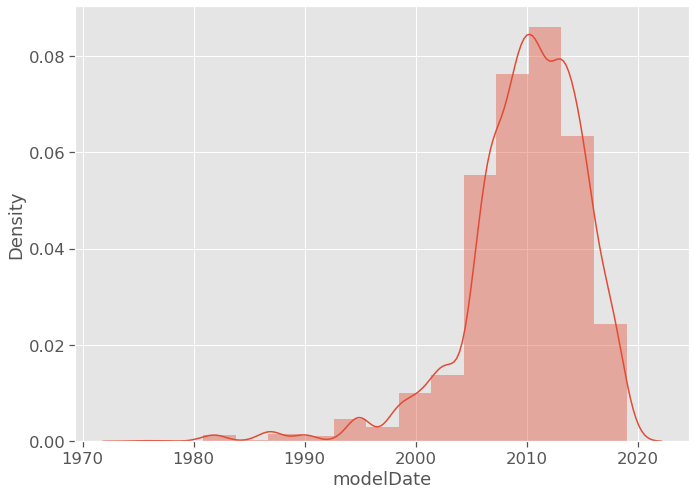

In [87]:
numeric_info(data.modelDate, bins=15)

Год начала выпуска модели имеет ассиметричное распределение с длинным левым концом. Производство самой старой марки началось в 1975 году, самой новой - в 2019. Первый, второй и третий квартили равны соответственно 2007, 2011 и 2014. 

## name (основные характеристики автомобиля)

Характерное значение этого признака: 525xi 2.5 AT (218 л.с.) 4WD

здесь 525xi - модель, 

2.5 - объем двигателя в литрах (дублирует engineDisplacement),

AT - тип трансмиссии (дублирует vehicleTransmission), 

218 - мощность двигателя в лошадиных силах (дублирует enginePower), 

4WD - тип привода (дублирует Привод). 

Так как для всех параметров, кроме модели в датасете есть дублирующие признаки, попробуем выделить только признак модели. Всего в датасете примерно 135 различных наименований моделей. Их анализ позволяет понять, что у большинства наименований первая цифра (если начинается с цифры и заканчивается буквой) означает принадлежность к серии, коих у бмв восемь (N Series). Например, 116i - первая серия, 523i - пятая. Однако некоторые начинаются просто с цифр, не заканчиваясь буквой 1.5 или 2.0, что скорее всего является объемом двигателя. 

Также имеются наименования, начинающиеся с буквы или целого слова (M135i, Competition). Что касается тех, кто начинается с буквы M, то их можно отнести к M - серии.  

In [15]:
models = []
for name in data.name:
    models.append(name.split()[0])
print(len(np.unique(models)))
np.unique(models)

135


array(['1.5', '1.5hyb', '116i', '118d', '118i', '120d', '120i', '125i',
       '130i', '135i', '18d', '18i', '2.0', '2.2', '20d', '20i', '218i',
       '220i', '23d', '23i', '25d', '25i', '28i', '3.0', '3.0d', '3.0i',
       '3.0sd', '3.0si', '30d', '30i', '316', '316i', '318d', '318i',
       '320d', '320i', '323i', '325i', '325xi', '328i', '330d', '330i',
       '330xd', '330xi', '335i', '335xi', '340i', '35d', '35i', '35is',
       '4.0', '4.4', '4.4i', '4.6is', '4.8i', '4.8is', '40d', '40i',
       '420d', '420i', '428i', '430i', '440i', '48i', '5.0', '50i', '518',
       '520Li', '520d', '520i', '523i', '525d', '525i', '525xd', '525xi',
       '528Li', '528i', '530Li', '530d', '530i', '530xd', '530xi', '535d',
       '535i', '540i', '545i', '550i', '620d', '630d', '630i', '640d',
       '640i', '645i', '650i', '725Ld', '728i', '730Ld', '730Li', '730d',
       '730i', '735Li', '735i', '740Ld', '740Li', '740d', '740i', '745Li',
       '745i', '750Ld', '750Li', '750d', '750i', '760Li

In [16]:
suspicious = ['1.5', '2.0', '2.2', '3.0', '4.0', '4.4', '5.0', 'Active', 'ActiveHybrid', 'CS', 'Competition', 'Electro', 'M135i',
              'M235i', 'M340i', 'M40d', 'M40i', 'M50d', 'M50i', 'M550d', 'M550i',
              'M760Li', 'M850i', 'sDrive18i', 'xDrive18d', 'xDrive20d',
              'xDrive20i']
summa = 0
for n in suspicious:
    summa += pd.Series(models).value_counts()[n]
    print(n, pd.Series(models).value_counts()[n])

print(round(summa/len(data)*100, 2), "%")

1.5 1
2.0 1
2.2 1
3.0 12
4.0 6
4.4 88
5.0 3
Active 1
ActiveHybrid 1
CS 1
Competition 13
Electro 1
M135i 1
M235i 2
M340i 1
M40d 1
M40i 5
M50d 30
M50i 1
M550d 6
M550i 2
M760Li 4
M850i 6
sDrive18i 4
xDrive18d 1
xDrive20d 5
xDrive20i 2
5.21 %


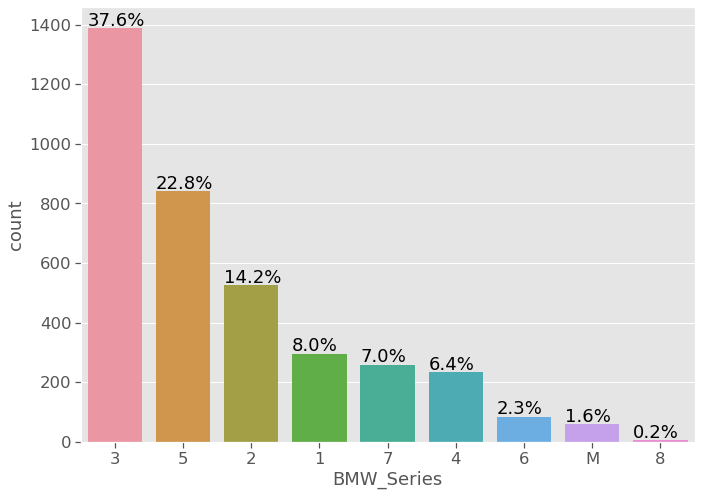

In [17]:
suspicious = ['1.5', '2.0', '2.2', '3.0', '4.0', '4.4', '5.0', 'Active', 'ActiveHybrid', 'CS', 'Competition', 'Electro',
              'sDrive18i', 'xDrive18d', 'xDrive20d',
              'xDrive20i']
models = []
for name in data.name:
    if name.split()[0] not in suspicious:
        models.append(name.split()[0][0])
series = pd.DataFrame(models, columns=["BMW_Series"])
categorical_info("BMW_Series", series, rotate=0)

## numberOfDoors (число дверей)

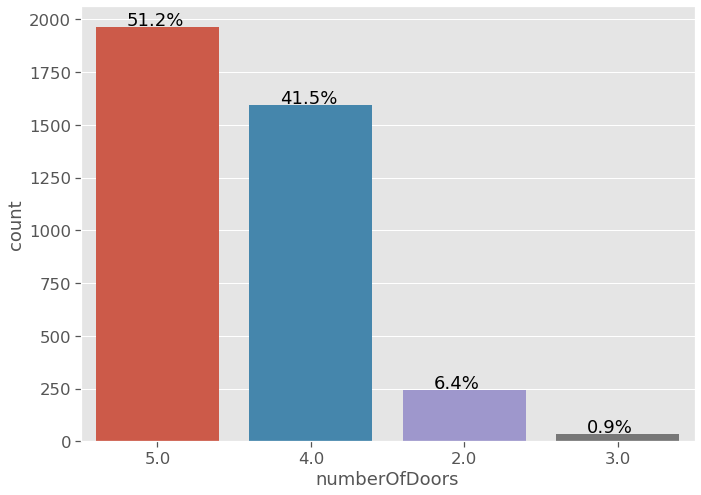

In [18]:
categorical_info("numberOfDoors", data, rotate=0, x_shift_mult=1/4)

## productionDate (год производства автомобиля)

min    1981.000000
max    2019.000000
25%    2010.000000
50%    2013.000000
75%    2016.000000
std       5.186576
Name: productionDate, dtype: float64


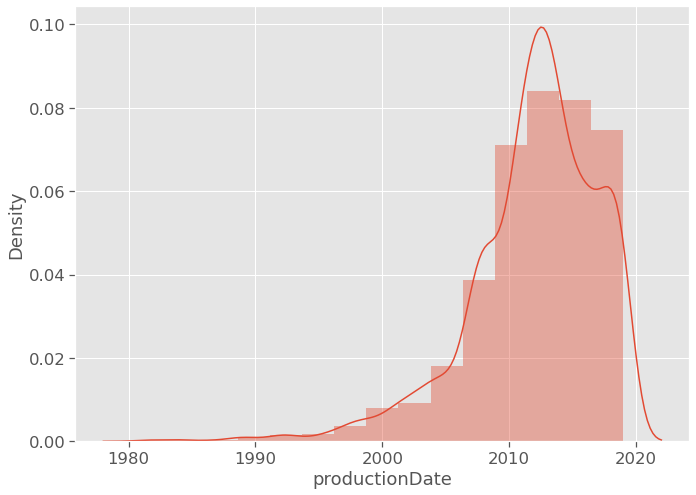

In [19]:
numeric_info(data.productionDate, bins=15)

Год производства автомобиля имеет ассиметричное распределение с длинным левым концом. Самый старый автомобиль датасета был выпущен в 1981 году, самый новый - в 2019. Первый, второй и третий квартили равны соответственно 2010, 2013 и 2016. 

## vehicleConfiguration (конфигурация автомобиля)

Характерное значение этого признака HATCHBACK_5_DOORS AUTOMATIC 2.0, здесь 

HATCHBACK - тип кузова (дублирует bodyType)

5_DOORS - количество дверей (указано не у всех, дублирует numberOfDoors)

AUTOMATIC - тип трансмиссии (дублирует vehicleTransmission)

2.0 - объем двигателя в литрах (дублирует engineDisplacement)

Исключим признак из расмотрения, так как он дублирует уже имеющиеся признаки, находящиеся в более удобном виде  

## vehicleTransmission (тип трансмиссии)

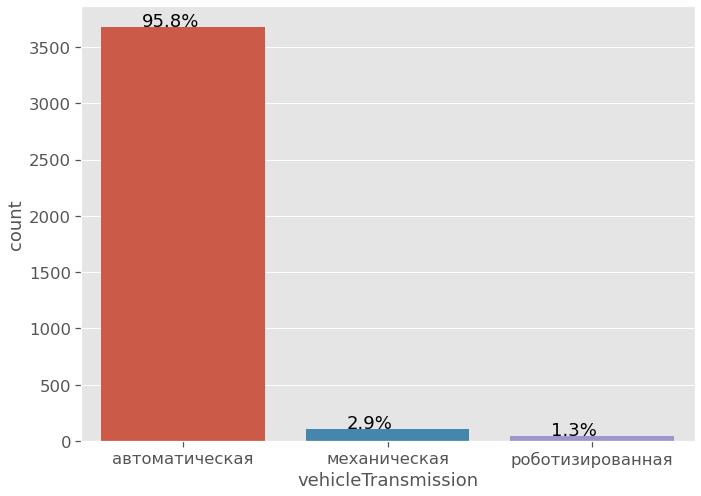

In [20]:
categorical_info("vehicleTransmission", data, rotate=0, x_shift_mult=1/4)

Подавляющее большинство автомобилей имеет автоматическую коробку передач (95.8%), механической коробкой оборудованы лишь 2.9% автомобилей, роботизированной - 1.3%.

## engineDisplacement (объём двигателя)

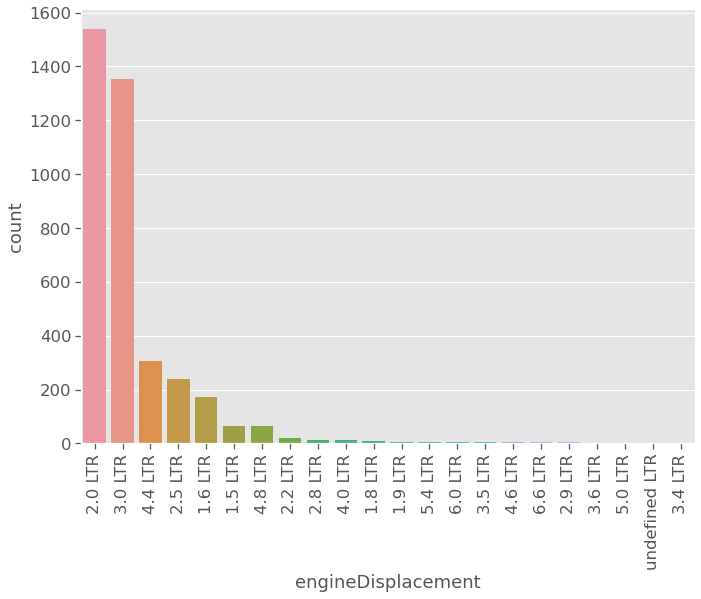

In [21]:
categorical_info("engineDisplacement", data, percentage=False)

Большинство двигателей автомобилей датасета имеют объем 2 литра (40%) и 3 литра (35%). Двигатели объемом 4.4, 2.5 и 1.6 литра составляют 7, 6 и 5% выборки соотвественно. Оставшиеся 6% делят между собой 16 вариантов объемов двигателей, включая один двигатель (823 строка данных) неизвестного объема (электро). 

In [22]:
for row in range(len(data)):
    if data.iloc[row].engineDisplacement == "undefined LTR":
        print(
            f'Тип двигаеля неопределенного объема: {data.iloc[row].fuelType}')

Тип двигаеля неопределенного объема: электро


In [23]:
data.engineDisplacement.value_counts(normalize=True)

2.0 LTR          0.400834
3.0 LTR          0.352619
4.4 LTR          0.079489
2.5 LTR          0.062288
1.6 LTR          0.045087
1.5 LTR          0.017201
4.8 LTR          0.016680
2.2 LTR          0.005212
2.8 LTR          0.003649
4.0 LTR          0.003388
1.8 LTR          0.002606
1.9 LTR          0.001824
5.4 LTR          0.001564
6.0 LTR          0.001303
3.5 LTR          0.001042
4.6 LTR          0.001042
6.6 LTR          0.001042
2.9 LTR          0.001042
3.6 LTR          0.000782
5.0 LTR          0.000782
undefined LTR    0.000261
3.4 LTR          0.000261
Name: engineDisplacement, dtype: float64

## enginePower (мощность двигателя)

In [24]:
powers = []
for value in data.enginePower:
    powers.append(int(value.split()[0]))

min     90.000000
max    625.000000
25%    184.000000
50%    231.000000
75%    272.000000
std     91.429294
dtype: float64


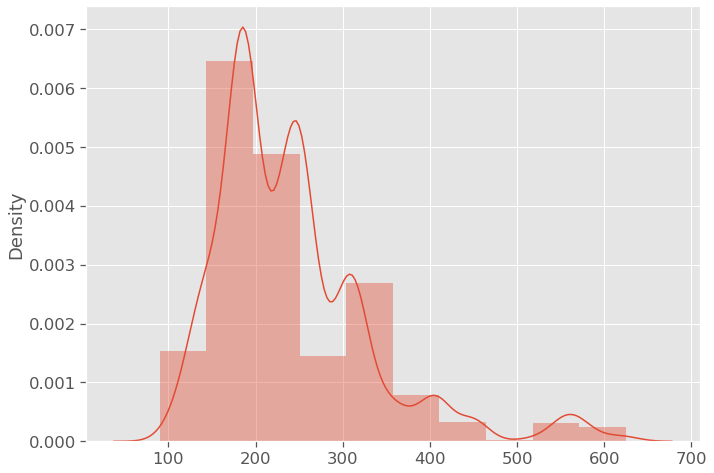

In [25]:
numeric_info(pd.Series(powers), bins=10)

Мощности двигателей автомобилей выборки находятся в диапазоне от 90 до 625 л.с. Первый, второй и третий квартили 
равны соответственно 184, 231 и 272 л.с. Распределение несимметрично, имеет длинный правый "хвост". В распределении признака наблюдается несколько мод: вблизи (примерно) 190, 250 и 310 л.с.

## description (описание автомобиля)

Признак содержит в себе описание автомобиля, которое составил продавец. Размер описания варьируется от очень скупого "Машина собиралась под заказ!" до очень обширного, содержащего в себе очень подробное описание комплектации автомобиля. Данные во многом дублируют имеющиеся признаки в более удобном формате, такие, например, как Комплектация. Исключим признак из расмотрения.

## mileage (пробег)

min          1.000000
max    1000000.000000
25%      58562.000000
50%     108000.000000
75%     160789.000000
std      85125.949826
Name: mileage, dtype: float64


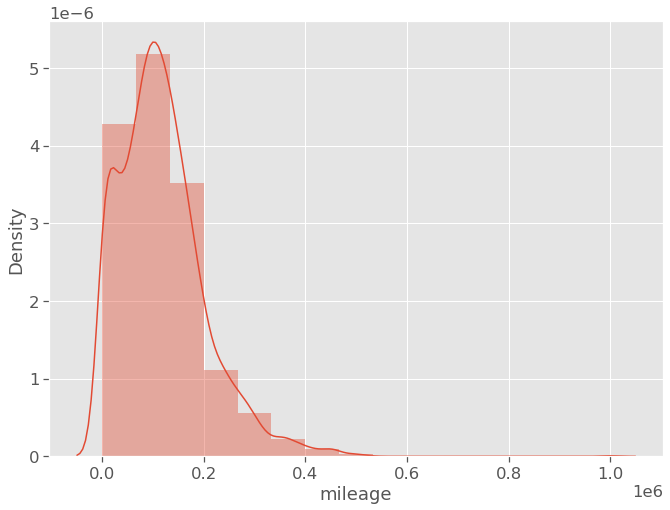

In [26]:
numeric_info(data.mileage, bins=15)

Пробег автомобилей в датасете варьируется от 1 до 1000000 км. Первый, второй и третий квартили равны соответственно 58500, 108000 и 160700. Распределение признака ассиметрично, с правым "хвостом"

## Комплектация

In [27]:
data.Комплектация[0]

'[\'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омывател

Признак содержит описание комплектации автомобиля. Необходимо разобраться с парсингом данных. Сделаем это при рассмотрении данных тренировочной выборки в дальнейшем. 

## Привод

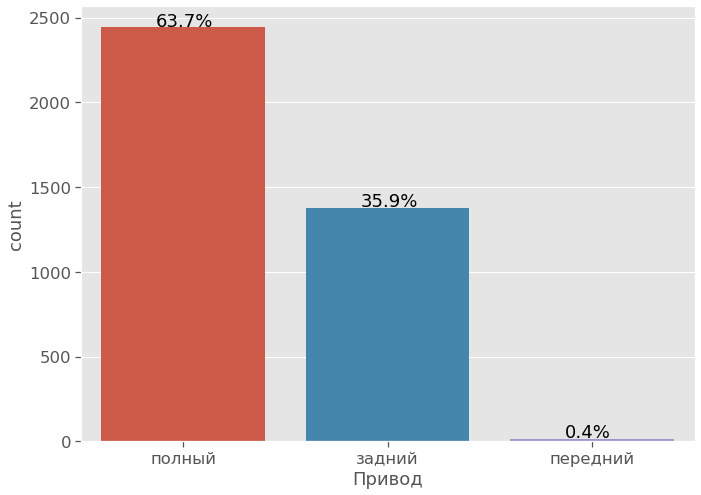

In [28]:
categorical_info("Привод", data, rotate=0, x_shift_mult=1/3)

Подавляющее большинство автомобилей датасета имеет полный привод (63.7%), на втором месте - задний привод (35.9%), предний привод составляет всего 0.4% выборки

## Руль 

In [29]:
print(
    f'Датасет представлен автомобилями с типом руля: {data["Руль"].unique()[0]}')

Датасет представлен автомобилями с типом руля: Левый


## Владельцы

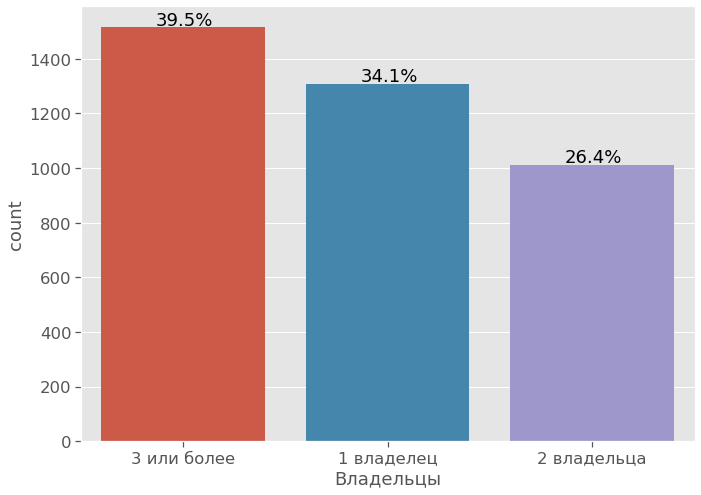

In [30]:
categorical_info("Владельцы", data, rotate=0, x_shift_mult=1/3)

Распределение числа владельцев автомобиля таково: у 39.5% авто было 3 и более владельцев, у 34.1% 1 владелец и у 26.4% - два владельца

## ПТС

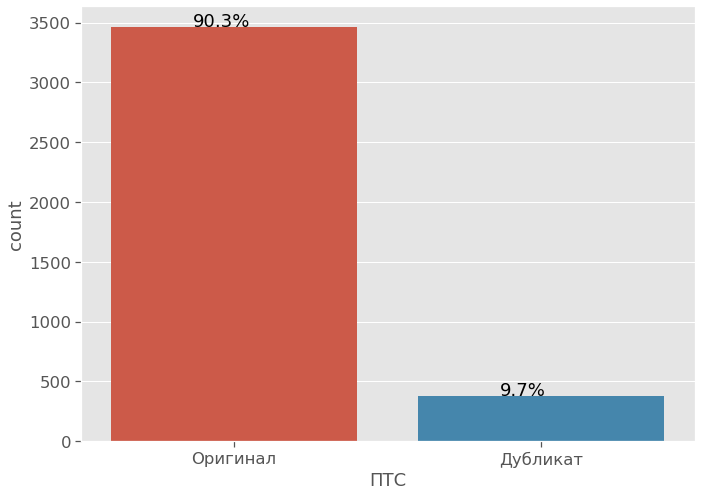

In [31]:
categorical_info("ПТС", data, rotate=0, x_shift_mult=1/3)

Подавляющее число автомобилей датасета имеют оригинал птс (90.3%), дубликат птс есть у 9.7% авто

## Таможня

In [32]:
print(
    f'Датасет представлен автомобилями с состоянием: {data["Таможня"].unique()[0]}')

Датасет представлен автомобилями с состоянием: Растаможен


## Владение

In [33]:
print(
    f'Признак содержит {round(100*sum(data["Владение"].isna())/len(data),1)}% пропусков, исключим его из рассмотрения')

Признак содержит 54.3% пропусков, исключим его из рассмотрения


## Id 

Признак представляет собой порядковый номер автомобиля в датасете. Неинформативный признак, исключим его из рассмотрения

## Выводы

Датасет представляет собой довольно полное описание характеристик автомобиля. Данные чистые, в большинстве своем не содержат пропусков, за исключением признака **Владение** (54% пропусков), который был исключен из рассмотрения. 

Также ввиду отсутствия информативности возможно будут исключены из дальнейшего рассмотрения признаки (если в тренировочной выборке не будет вариаций этого признака): 

**brand**, **Руль**, **Состояние**, **Таможня**, **Id**.

По причине дублирования данных, представленных в более удобном формате, исключены из рассмотрения признаки:

**vehicleConfiguration** и **description** 

Из 23 признаков были исключены 8, оставшиеся 15 предлагается использовать для моделирования. Ниже приведена сводная таблица признаков. Тип "mixed" означает смешанный тип данных. 

In [34]:
f_type = ["categorical", "categorical", "categorical", "categorical", "numeric", "mixed",
          "numeric", "numeric", "categorical", "categorical", "categorical", "numeric", "mixed",
          "numeric", "mixed", "categorical", "categorical", "categorical", "categorical",
          "categorical", "categorical", "categorical", "numeric"]

in_model = ["Yes", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No",
            "Yes", "Yes", "Yes", "No", "No", "Yes", "Yes", "No", "No", "No"]

table = {'Feature': list(data.columns),

         'Type': f_type,

         'In_model': in_model
         }

pd.DataFrame.from_dict(table)

,Feature,Type,In_model
0,bodyType,categorical,Yes
1,brand,categorical,No
2,color,categorical,Yes
3,fuelType,categorical,Yes
4,modelDate,numeric,Yes
5,name,mixed,Yes
6,numberOfDoors,numeric,Yes
7,productionDate,numeric,Yes
8,vehicleConfiguration,categorical,No
9,vehicleTransmission,categorical,Yes


Проведённый разведовательный анализ полезен не только тем, что позволил подробно ознакомиться с датасетом, но и тем, что благодаря нему мы можем определить данные, которые будем собирать для обучения модели.

# 2. Парсинг данных

В качестве источника данных был выбран сайт auto.ru. Проведенный EDA тестовой выборки позволил сузить область поиска до автомобилей марки BMW. Кроме того, был обозначен круг искомых характеристик автомобилей. Сбор данных осуществлялся при помощи библиотеки requests. Сайт auto.ru формирует файл json по запросу пользователя. Работа с этим файлом велась при помощи библиотеки json.

In [35]:
import pandas as pd
import requests
import json
import numpy as np
from tqdm import tqdm

# Заголовки для запроса
headers = """Accept: */*
Accept-Encoding: gzip, deflate, br
Accept-Language: ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7,sr;q=0.6
Connection: keep-alive
Content-Length: 123
content-type: application/json
Cookie: autoru_sid=a%3Ag5f854d4d239lo054d3itvaa385q9j10.babf6886aea8dcb9809759d5623bf1a0%7C1602571597391.604800.31OE6YecVtYZvaPcR4ZQWA.C-GDDno0U51D6oKi9x5I-YFyy4wQm5-usOsvzQwNCHw; autoruuid=g5f854d4d239lo054d3itvaa385q9j10.babf6886aea8dcb9809759d5623bf1a0; suid=a4f9f1fd202852986546ed7bbca3d872.c79df47b54226e63c5ca026dec550481; yuidcs=1; cmtchd=MTYwMjU3MTU5OTE5Mg==; crookie=9baR9HsEbP1vChU6bXlG9DVbz4kJoTELbCxgH/gUKyvCeXMXE8vFEKNGA4PgIOq7Zub73qA3+fHO3qtsXriSsjmR7j8=; _ym_uid=160257160147791175; _ym_wasSynced=%7B%22time%22%3A1602585535287%2C%22params%22%3A%7B%22eu%22%3A0%7D%2C%22bkParams%22%3A%7B%7D%7D; yuidlt=1; yandexuid=627707231600704444; my=YwA%3D; counter_ga_all7=1; gids=213; _ga=GA1.2.137572421.1602613334; _gid=GA1.2.982497803.1602613334; _csrf_token=bb9b62ad7742b9a1f875cec374ed2f0bfa8e4a22789e61f2; gdpr=0; _ym_isad=2; gradius=1000; from=google-search; cycada=10DfptICbRpXdINEwvPGmwNDjX5WVAnGZHjsbvcFPGw=; X-Vertis-DC=sas; _ym_visorc_22753222=b; from_lifetime=1602670486832; _ym_d=1602670486; _gat=1
Host: auto.ru
Origin: https://auto.ru
Referer: https://auto.ru/moskva/cars/bmw/all/
Sec-Fetch-Dest: empty
Sec-Fetch-Mode: same-origin
Sec-Fetch-Site: same-origin
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36
x-client-app-version: 202010.13.191217
x-client-date: 1602670514251
x-csrf-token: bb9b62ad7742b9a1f875cec374ed2f0bfa8e4a22789e61f2
x-page-request-id: 5be6179dcfb5a5a310cf3ec758e5e262
x-requested-with: fetch""".strip().split("\n")

# Cоздадим словарь
dict_headers = {}
for header in headers:
    key, val = header.split(": ")
    dict_headers[key] = val


def take_data(mark, series, page, headers):
    """Функция принимает на вход марку автомобиля (mark), серию (series), номер страницы (page) 
       и заголовки (headers).Возвращает json c характеристиками автомобиля.
    """

    # Путь запроса
    url = 'https://auto.ru/-/ajax/desktop/listing/'

    # Параметры для запроса
    params = {
        'catalog_filter': [{"mark": mark, "model": series}],
        'section': "all",
        'category': "cars",
        'geo_id': [213], # Область поиска Москва и 1000 км от нее
        'geo_radius': 1000, # и 1000 км от нее
        'sort': "fresh_relevance_1-desc",
        'page': page
    }

    # Делаем post запрос на url
    response = requests.post(url, json=params, headers=dict_headers)
    return response.json()['offers']

In [36]:
result = pd.DataFrame(columns=["body_type", "brand", "color", "fuel_type",
                               "model_date_begin", "model_date_end", "name", "model_name",
                               "number_of_doors", "production_date", "vehicle_transmission",
                               "engine_displacement", "engine_power", "mileage", "complectation",
                               "gear_type", "steering_wheel", "not_damage", "owners",
                               "pts_origin", "custom_clear", "price"])

In [37]:
# Количество машин на одной странице сайта
cars_per_page = 37

# Словарь -  серия: количество авто на сайте
series_count = {"1ER": 391,
                "2ER": 93,
                "3ER": 2265,
                "4ER": 93,
                "5ER": 2383,
                "6ER": 215,
                "7ER": 724,
                "8ER": 44,
                "2ACTIVETOURER": 8,
                "2GRANDTOURER": 17,
                "M1": 1,
                "M2": 2,
                "M3": 21,
                "M4": 5,
                "M5": 56,
                "M6": 15,
                "M8": 3,
                "I3": 46,
                "I8": 6,
                "X1": 553,
                "X2": 37,
                "X3": 1009,
                "X3_M": 2,
                "X4": 252,
                "X4_M": 2,
                "X5": 1766,
                "X5_M": 95,
                "X6": 748,
                "X6_M": 164,
                "X7": 166,
                "Z1": 1,
                "Z3": 7,
                "Z3M": 3,
                "Z4": 26
                }

Запустим сбор данных. Так как не для каждого авто имелись запрашиваемые данные, пришлось воспользоваться оператором try-catch.

In [37]:
# print("BMW auto info parsing start...")
# for key, val in series_count.items():
#     print("Series to parse:", key)
#     for page in tqdm(range(1, val//cars_per_page+2)):
#         data = take_data("BMW", key, page, dict_headers)
#         for i in range(len(data)):
#             to_append = []
#             try:
#                 to_append.append(data[i]['vehicle_info']
#                                  ['configuration']['human_name'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['vehicle_info']['mark_info']['name'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]["color_hex"])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['vehicle_info']
#                                  ['tech_param']['engine_type'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['vehicle_info']
#                                  ['super_gen']['year_from'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['vehicle_info']
#                                  ['super_gen']['year_to'])
#             except:
#                 to_append.append(2020)

#             try:
#                 to_append.append(data[i]['vehicle_info']
#                                  ['tech_param']['human_name'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['vehicle_info']['model_info']['name'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['vehicle_info']
#                                  ['configuration']['doors_count'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['documents']['year'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['vehicle_info']
#                                  ['tech_param']['transmission'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['vehicle_info']
#                                  ['tech_param']['displacement'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['vehicle_info']
#                                  ['tech_param']['power'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['state']['mileage'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(str(data[i]['vehicle_info']['equipment']))
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['vehicle_info']
#                                  ['tech_param']['gear_type'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['vehicle_info']['steering_wheel'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['state']['state_not_beaten'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['documents']['owners_number'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['documents']['pts'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['documents']['custom_cleared'])
#             except:
#                 to_append.append(np.nan)

#             try:
#                 to_append.append(data[i]['price_info']['RUR'])
#             except:
#                 to_append.append(np.nan)

#             result.loc[len(result)] = to_append

Удалим дубликаты записей перед сохранением данных, а также записи, в которых отсутствует цена (price)

In [38]:
# result = result.drop_duplicates()
# result.dropna(subset=['price'], inplace=True)

In [39]:
# result.to_csv('raw_data.csv', index=False, header=True)

In [40]:
# print(
#     f'В результате работы программы удалось собрать данные о {result.shape[0]} автомобилях')

# 3. Разведовательный анализ (EDA) для тренировочного датасета

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Рассмотрим тренировочную выборку, полученную в результате сбора данных с auto.ru:

In [39]:
train = pd.read_csv("raw_data.csv")

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10367 entries, 0 to 10366
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   body_type             10367 non-null  object 
 1   brand                 10367 non-null  object 
 2   color                 10367 non-null  object 
 3   fuel_type             10367 non-null  object 
 4   model_date_begin      10367 non-null  int64  
 5   model_date_end        10367 non-null  int64  
 6   name                  10367 non-null  object 
 7   model_name            10367 non-null  object 
 8   number_of_doors       10367 non-null  int64  
 9   production_date       10367 non-null  int64  
 10  vehicle_transmission  10367 non-null  object 
 11  engine_displacement   10367 non-null  int64  
 12  engine_power          10367 non-null  int64  
 13  mileage               10367 non-null  int64  
 14  complectation         10367 non-null  object 
 15  gear_type          

Видим, что тренировочный датасет содержит **10367** записей, и **22** признака. Для детального анализа данных используем приведенные функции.

Чтобы производить унификацию тренировочной и тестовой выборки, загрузим тестовый датасет:

In [41]:
test = pd.read_csv("test.csv")

In [42]:
def categorical_info(column_name, train, rotate=90, x_shift_mult=0, percentage=True):
    """Рисует распределение категориальных признаков и отображает их процентное содержание"""

    ax = sns.countplot(x=column_name,
                       data=train,
                       order=train[column_name].value_counts().index, orient="h")
    if percentage:
        total = len(train[column_name])
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + x_shift_mult*p.get_width()
            y = p.get_y() + p.get_height()+8
            ax.annotate(percentage, (x, y))
    plt.xticks(rotation=rotate)


def numeric_info(train, bins=10):
    """Печатает описательные статистики числового признака, а также рисует его распределение"""

    print(train.describe()[["min", "max", "25%", "50%", "75%", "std"]])
    sns.distplot(train, bins=bins)


def get_differences(obj1, obj2):
    """Выводит на печать отличия в признаках выборок, возвращает индексы отличных элементов"""

    dif12 = list(set(list(obj1.value_counts().index)) -
                 set(list(obj2.value_counts().index)))
    print("================================")
    print("Train - Test differences:\n")
    print(obj1.value_counts()[dif12]) if len(
        dif12) != 0 else print("No differences")
    dif21 = list(set(list(obj2.value_counts().index)) -
                 set(list(obj1.value_counts().index)))
    print("================================")
    print("Test - Train differences:\n")
    print(obj2.value_counts()[dif21]) if len(
        dif21) != 0 else print("No differences")
    return dif12, dif21


def delete_differences(data, column_name, dif):
    """Удаляет найденные отличия из выборок"""
    # функция применялась при первой попытке приводить тренировочные данные под тестовые,
    # то есть удалять те записи из тренировочной выборки, значения признаков которых
    # отсутствуют в тестовой выборке. Проведённые эксперименты показали, что лучше их оставить
    before = data.shape[0]
    print(f"Число записей до удаления: {before}")
    data = data[~data[column_name].isin(dif[0])].reset_index(drop=True)
    after = data.shape[0]
    print(f"Число записей после удаления: {after}")
    print(f"Удалено {before-after} записей со значениями {dif[0]}")
    return data

##  body_type  (тип кузова)

In [43]:
train.body_type = train.body_type.map(lambda x: x.lower())

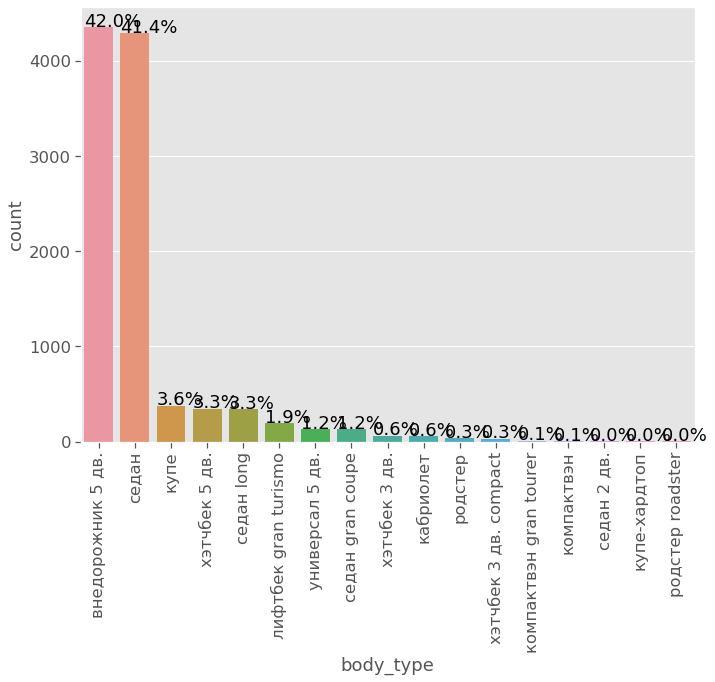

In [44]:
categorical_info("body_type", train, rotate=90)

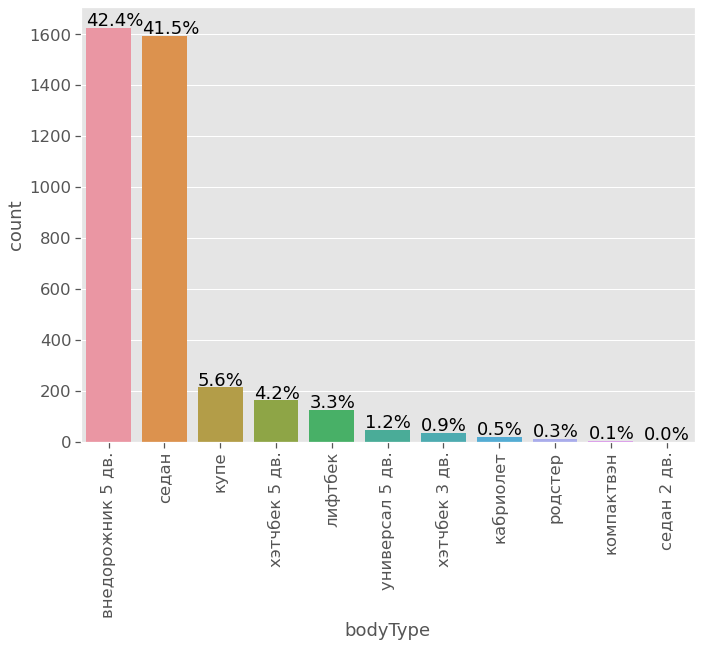

In [45]:
categorical_info("bodyType", test, rotate=90)

Посмотрим на отличия датасетов. Видим, что в train есть типы кузовов, отличающиеся по названию от тех, что есть в test. По сути, это все те же кузова, но с дополнительными названиями типа gran tourer. Избавимся от дополнительных названий, оставив основные.

In [46]:
difs = get_differences(train.body_type, test.bodyType)

Train - Test differences:

родстер roadster            1
хэтчбек 3 дв. compact      30
лифтбек gran turismo      193
седан long                341
компактвэн gran tourer      9
купе-хардтоп                2
седан gran coupe          127
Name: body_type, dtype: int64
Test - Train differences:

лифтбек    125
Name: bodyType, dtype: int64


In [47]:
add_names = {"купе-хардтоп": "купе",    
             "лифтбек gran turismo": "лифтбек",
             "родстер roadster": "родстер",
             "седан long": "седан",
             "компактвэн gran tourer": "компактвэн",
             "седан gran coupe": "седан",
             "хэтчбек 3 дв. compact": "хэтчбек 3 дв."
            }

train.body_type.replace(add_names, inplace=True)

Сделаем замену названий на англоязычные аналоги:

In [48]:
body_dict = {'внедорожник 5 дв.': 'SUV',
             'седан': 'sedan',
             'купе': 'coupe',
             'хэтчбек 5 дв.': 'hatchback5',
             'лифтбек': 'liftback',
             'универсал 5 дв.': 'station_wagon',
             'хэтчбек 3 дв.': 'hatchback3',
             'кабриолет': 'cabriolet',
             'родстер': 'roadster',
             'компактвэн': 'compactvan',
             'седан 2 дв.': 'sedan2'
             }
train.body_type = train.body_type.map(body_dict)
test.bodyType = test.bodyType.map(body_dict)

Унифицируем название признака и проверим тип:

In [49]:
test.rename(columns={"bodyType": "body_type"}, inplace=True)

In [50]:
train.body_type.dtype == test.body_type.dtype

True

Посмотрим на распределения признака в обеих выборках после всех преобразований:

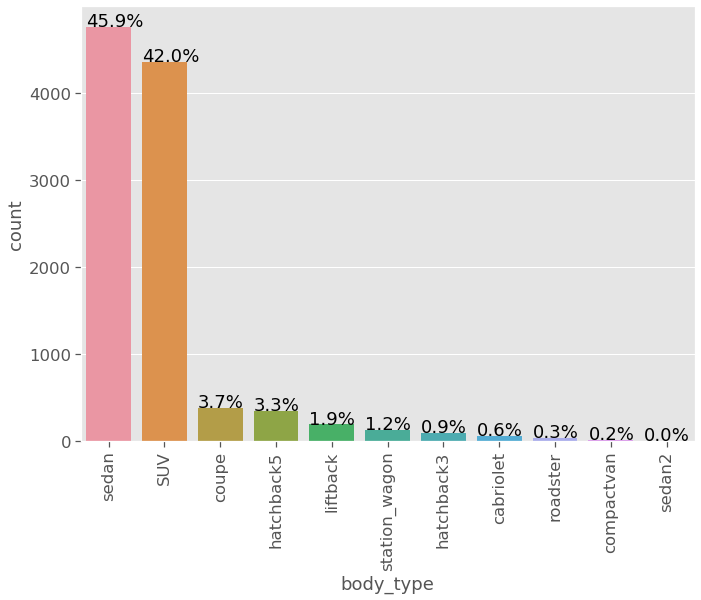

In [51]:
categorical_info("body_type", train, rotate=90)

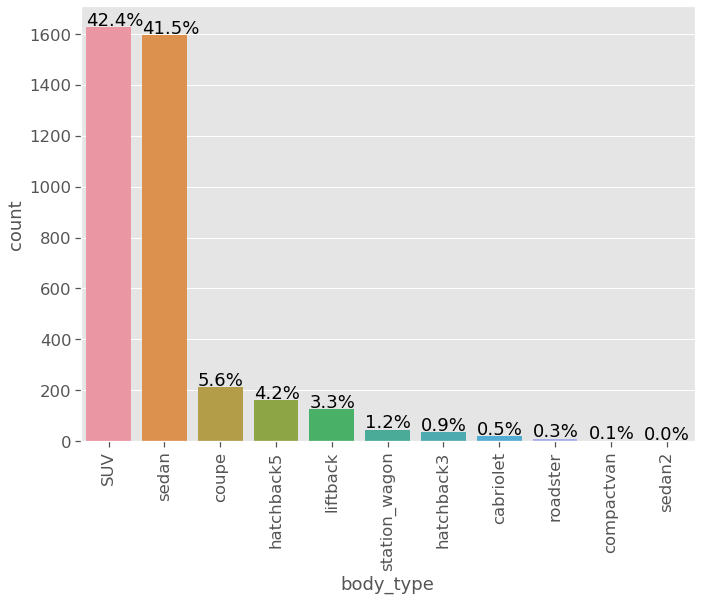

In [52]:
categorical_info("body_type", test, rotate=90)

## brand (марка автомобиля)

Убедимся, что данные, полученные с сайта, соответствуют марке BMW:

In [53]:
if len(train.brand.unique()) == 1:
    print(
        f'Датасет полностью представлен автомобилями марки {train.brand.unique()[0]}')

Датасет полностью представлен автомобилями марки BMW


## color (цвет автомобиля)

Преобразуем цвета тренировочного датасета из шестнадцатиричного формата в слова (русскоязычные):

In [54]:
color_dict = {'FAFBFB': 'белый',
              'CACECB': 'серебристый',
              '0000CC': 'синий',
              '97948F': 'серый',
              '040001': 'чёрный',
              'EE1D19': 'красный',
              '200204': 'коричневый',
              '007F00': 'зелёный',
              'C49648': 'бежевый',
              '4A2197': 'фиолетовый',
              'FF8649': 'оранжевый',
              '22A0F8': 'голубой',
              'FFC0CB': 'розовый',
              '660099': 'пурпурный',
              'DEA522': 'золотистый',
              'FFD600': 'жёлтый'
              }
train.color = train.color.map(color_dict)

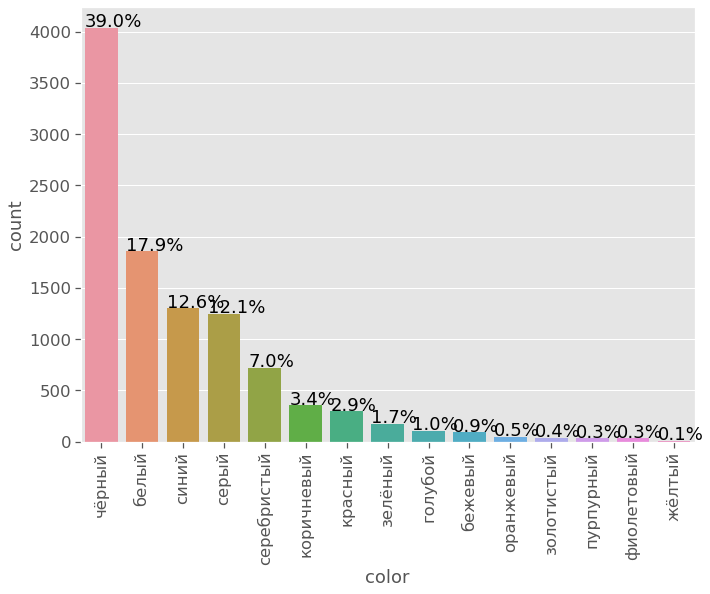

In [55]:
categorical_info("color", train, rotate=90)

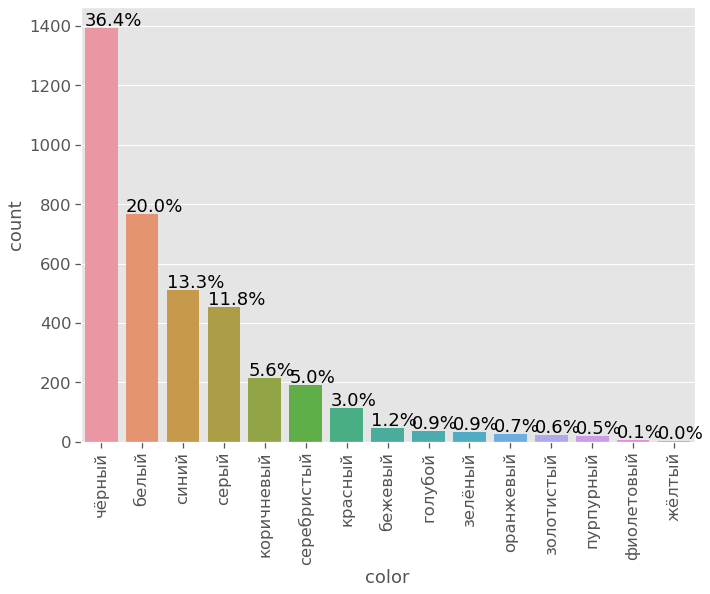

In [56]:
categorical_info("color", test, rotate=90)

Посмотрим на отличия в цветовой гамме:

In [57]:
difs = get_differences(train.color, test.color)

Train - Test differences:

No differences
Test - Train differences:

No differences


Сделаем замену названий цветов на англоязычные аналоги:

In [58]:
color_dict = {'белый': 'white',
              'серебристый': 'silver',
              'синий': 'dark_blue',
              'серый': 'grey',
              'чёрный': 'black',
              'красный': 'red',
              'коричневый': 'brown',
              'зелёный': 'green',
              'бежевый': 'biege',
              'фиолетовый': 'violet',
              'оранжевый': 'orange',
              'голубой': 'blue',
              'пурпурный': 'purple',
              'золотистый': 'golden',
              'жёлтый': 'yellow'
              }
test.color = test.color.map(color_dict)
train.color = train.color.map(color_dict)

Посмотрим на распределения признака в обеих выборках после всех преобразований:

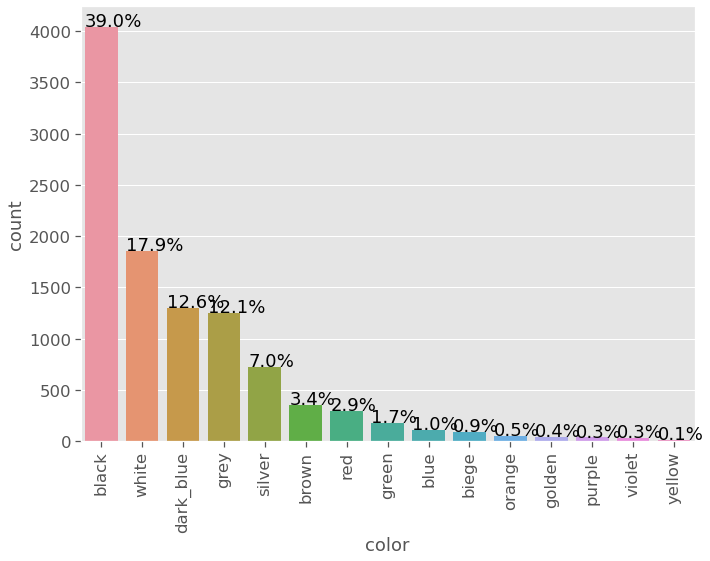

In [60]:
categorical_info("color", train, rotate=90)

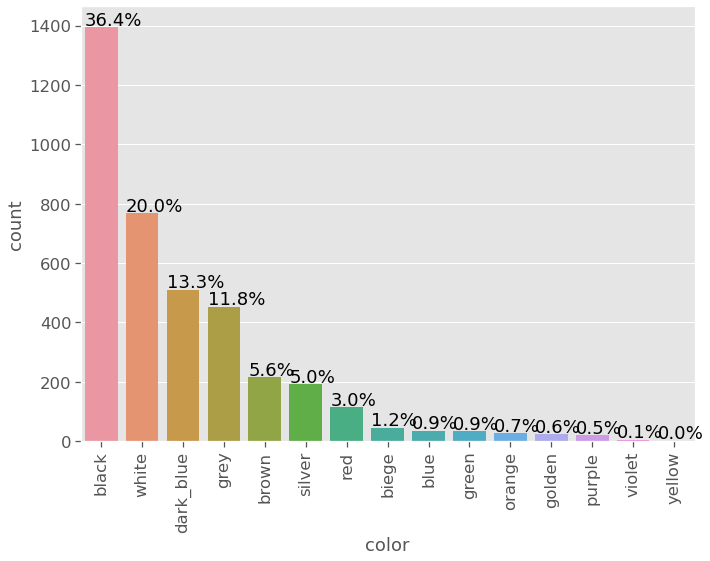

In [61]:
categorical_info("color", test, rotate=90)

In [62]:
train.color.dtype == test.color.dtype

True

## fuelType (тип двигателя)

Переименуем названия типов двигателей и посмотрим на распределение признака в датасетах:

In [63]:
fuel_dict = {'GASOLINE': "бензин",
             'DIESEL': "дизель",
             'HYBRID': "гибрид",
             'ELECTRO': "электро"
             }
train.fuel_type = train.fuel_type.map(fuel_dict)

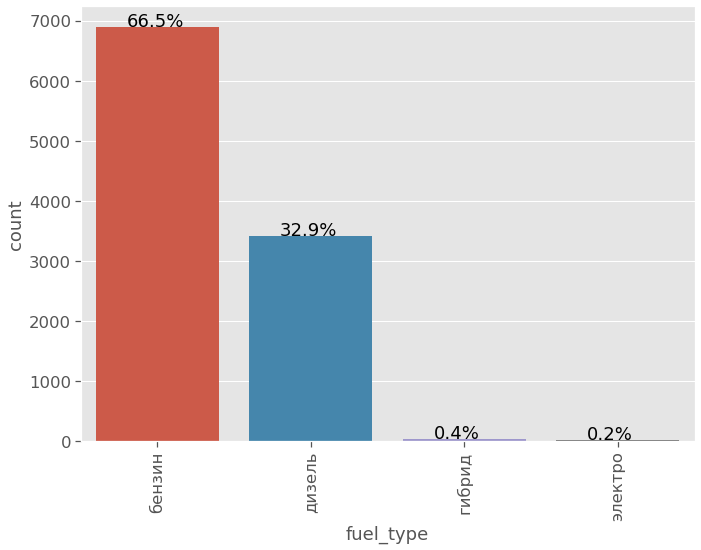

In [64]:
categorical_info("fuel_type", train, rotate=90, x_shift_mult=1/4)

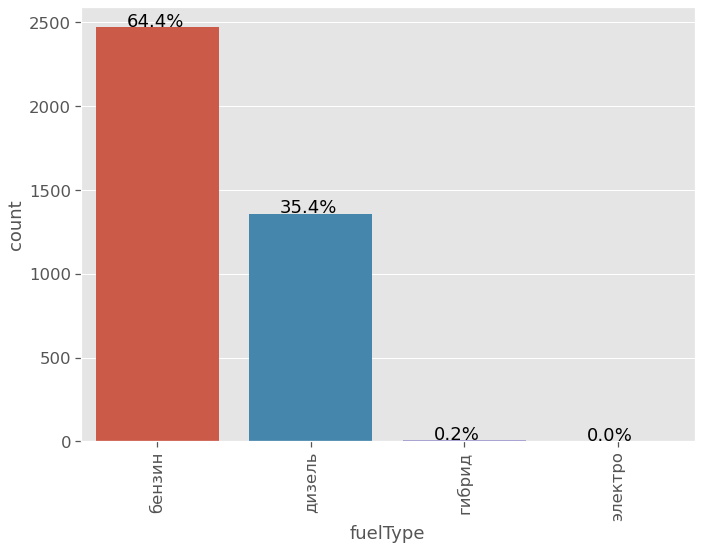

In [65]:
categorical_info("fuelType", test, rotate=90, x_shift_mult=1/4)

Видим, что распределения признака в обеих выборках очень похожи. Сделаем унификацию названия признака, а также заменим названия на англоязычные:

In [66]:
test.rename(columns={"fuelType": "fuel_type"}, inplace=True)

In [67]:
fuel_dict = {"бензин": "petrol",
             "дизель": "diesel",
             "гибрид": "hybrid",
             "электро": "electro"
             }

train.fuel_type = train.fuel_type.map(fuel_dict)
test.fuel_type = test.fuel_type.map(fuel_dict)

Посмотрим на распределения признака в обеих выборках после всех преобразований:

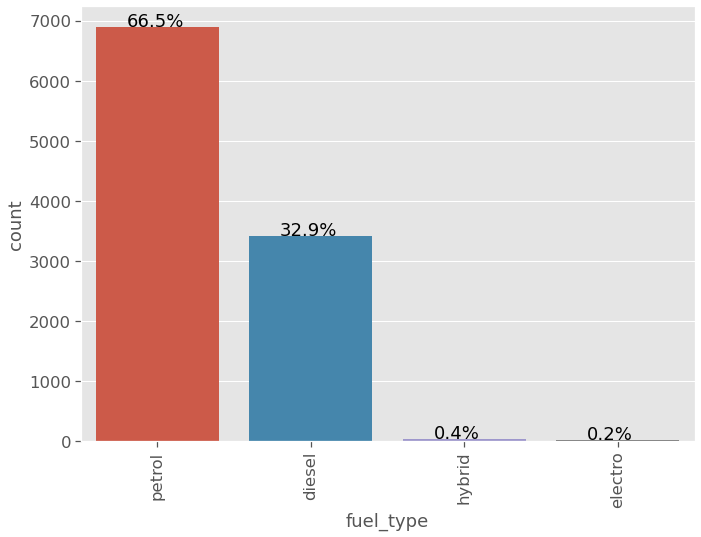

In [68]:
categorical_info("fuel_type", train, rotate=90, x_shift_mult=1/4)

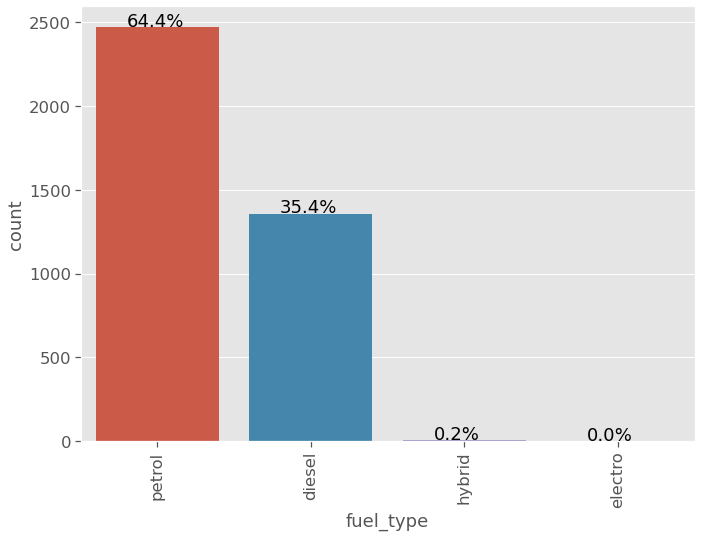

In [84]:
categorical_info("fuel_type", test, rotate=90, x_shift_mult=1/4)

In [85]:
train.fuel_type.dtype == test.fuel_type.dtype

True

## model_date_begin (год начала выпуска модели)

Переведём год для test из float64 в int32 (совет от автора baseline)

In [86]:
test.modelDate = test.modelDate.astype("int32")
train.model_date_begin = train.model_date_begin.astype("int32")

AttributeError: 'DataFrame' object has no attribute 'modelDate'

min    1972.000000
max    2020.000000
25%    2005.000000
50%    2009.000000
75%    2015.000000
std       8.007265
Name: model_date_begin, dtype: float64


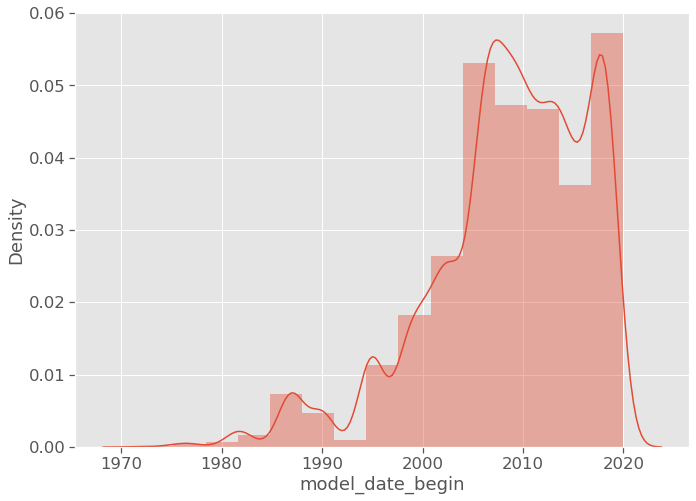

In [89]:
numeric_info(train.model_date_begin, bins=15)

min    1975.000000
max    2019.000000
25%    2007.000000
50%    2011.000000
75%    2014.000000
std       5.451623
Name: modelDate, dtype: float64


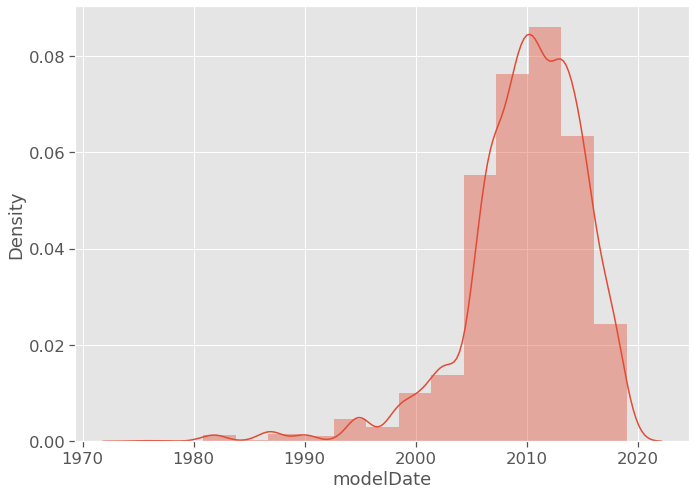

In [75]:
numeric_info(test.modelDate, bins=15)

Из визуального анализа распределений следует, что они во многом схожи. Посмотрим на отличия:

In [88]:
difs = get_differences(train.model_date_begin, test.modelDate)

AttributeError: 'DataFrame' object has no attribute 'modelDate'

Действительно, в тренировочных данных присутствуют автомобили, производство которых началось в 2020 году и даже автомобили 1972 года. 

In [74]:
test.rename(columns={"modelDate": "model_date_begin"}, inplace=True)

Немного изменим зачение признака, оставив при этом его название, а именно: найдем количество лет, которое прошло с момента запуска модели в производство

In [79]:
train.model_date_begin = 2020 - train.model_date_begin
test.model_date_begin = 2020 - test.model_date_begin

Посмотрим на распределения признака в обеих выборках после всех преобразований:

min    1972.000000
max    2020.000000
25%    2005.000000
50%    2009.000000
75%    2015.000000
std       8.007265
Name: model_date_begin, dtype: float64


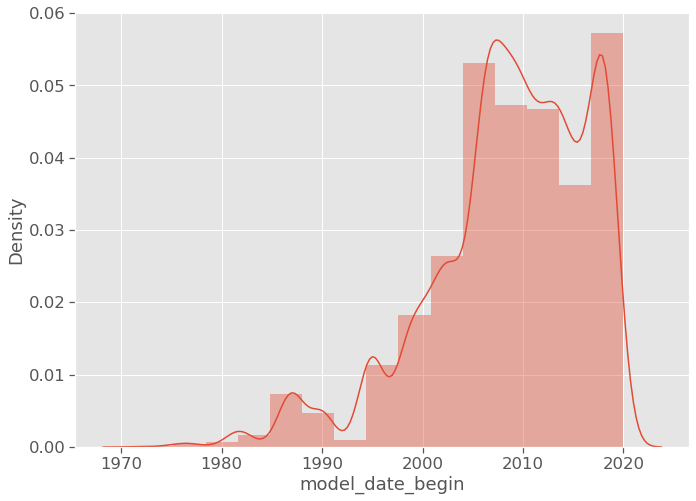

In [81]:
numeric_info(train.model_date_begin, bins=15)

min    1975.000000
max    2019.000000
25%    2007.000000
50%    2011.000000
75%    2014.000000
std       5.451623
Name: model_date_begin, dtype: float64


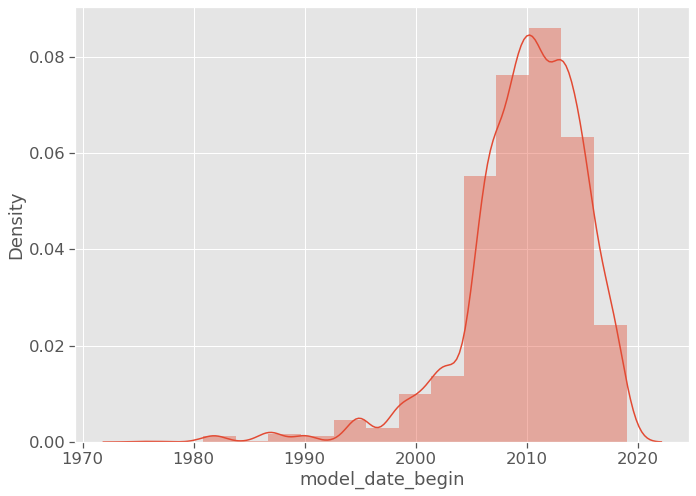

In [82]:
numeric_info(test.model_date_begin, bins=15)

In [78]:
train.model_date_begin.dtype == test.model_date_begin.dtype

False

In [82]:
train=train[(train['model_date_begin']>=1) & (train['model_date_begin']<=45)]

## model_date_end (год завершения выпуска модели)

min    1981.000000
max    2020.000000
25%    2010.000000
50%    2013.000000
75%    2019.000000
std       6.863938
Name: model_date_end, dtype: float64


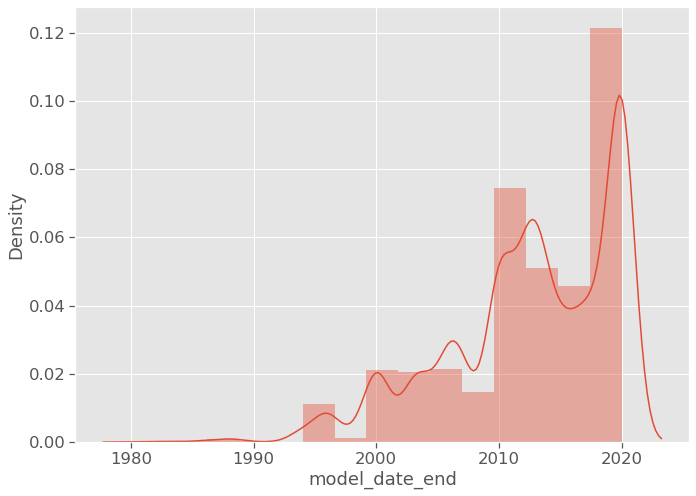

In [83]:
numeric_info(train.model_date_end, bins=15)

К сожалению, оказалось, что такой характеристики нет в тестовом датасете. 

## name (основные характеристики автомобиля)

Посмотрим на отличия в признаке. Видим, что в тренировочной выборке есть 210 конфигураций авто, которых нет в тестовой. И наоборот, в тестовой тоже есть автомобили, которых нет в тренировочной.

In [84]:
difs = get_differences(train.name, test.name)

Train - Test differences:

733i 3.2 MT (197 л.с.)                3
318d 2.0d MT (122 л.с.)               2
3.0d 3.0d MT (218 л.с.) 4WD           1
740Li xDrive 3.0 AT (340 л.с.) 4WD    1
330i 3.0 AT (272 л.с.) 4WD            1
                                     ..
528i 2.8 MT (184 л.с.)                2
330i xDrive 3.0 AT (272 л.с.) 4WD     1
320d 2.0d MT (136 л.с.)               2
3.0 AT (340 л.с.) 4WD                 1
3.8 MT (340 л.с.)                     2
Name: name, Length: 208, dtype: int64
Test - Train differences:

528i 3.0 AT (243 л.с.)                     1
120d xDrive 2.0d AT (190 л.с.) 4WD         1
420d 2.0d AT (184 л.с.)                    4
525xi 3.0 MT (218 л.с.) 4WD                1
528i 3.0 AT (230 л.с.)                     1
328i xDrive 2.0 MT (245 л.с.) 4WD          2
540i 4.0 AT (286 л.с.)                     1
420d 2.0d AT (190 л.с.)                    4
420i 2.0 AT (184 л.с.)                     9
750d xDrive 3.0d AT (381 л.с.) 4WD         1
420d xDrive 2.0d A

Посмотрим на количество вариаций признака, если выделять из него только первую часть до пробела. Количество различных названий 173 и 135 для тренировочной и тестовой выборки соответственно. 

In [85]:
models_train = set()
for name in train.name:
    models_train.add(name.split()[0])
print(len(models_train))

169


In [86]:
models_test = set()
for name in test.name:
    models_test.add(name.split()[0])
print(len(models_test))

135


In [87]:
np.sort(pd.Series(list(models_train)).values)

array(['0.7hyb', '1.5', '1.5hyb', '1.8', '1.9', '116d', '116i', '118d',
       '118i', '120d', '120i', '123d', '125i', '130i', '135i', '16d',
       '18d', '18i', '2.0', '2.5', '2.8', '20d', '20i', '216d', '218d',
       '218i', '220d', '220i', '23d', '23i', '25d', '25i', '28i', '3.0',
       '3.0d', '3.0i', '3.0sd', '3.0si', '3.2', '3.3', '3.5', '3.8',
       '30d', '30i', '315', '316', '316d', '316i', '318d', '318i', '320d',
       '320i', '323i', '324d', '325d', '325i', '325xi', '328i', '330d',
       '330e', '330i', '330xd', '330xi', '335d', '335i', '335xi', '340i',
       '35d', '35i', '35is', '4.0', '4.4', '4.4i', '4.6is', '4.8i',
       '4.8is', '4.9', '40d', '40i', '48i', '5.0', '50i', '518', '518i',
       '520Li', '520d', '520i', '523i', '524d', '525E', '525d', '525i',
       '525xd', '525xi', '528Li', '528i', '528xi', '530Li', '530d',
       '530i', '530xd', '530xi', '535Li', '535d', '535i', '535xi', '540i',
       '545i', '550i', '620d', '630d', '630i', '635d', '635i', '640

In [88]:
np.sort(pd.Series(list(models_train)).values)

array(['0.7hyb', '1.5', '1.5hyb', '1.8', '1.9', '116d', '116i', '118d',
       '118i', '120d', '120i', '123d', '125i', '130i', '135i', '16d',
       '18d', '18i', '2.0', '2.5', '2.8', '20d', '20i', '216d', '218d',
       '218i', '220d', '220i', '23d', '23i', '25d', '25i', '28i', '3.0',
       '3.0d', '3.0i', '3.0sd', '3.0si', '3.2', '3.3', '3.5', '3.8',
       '30d', '30i', '315', '316', '316d', '316i', '318d', '318i', '320d',
       '320i', '323i', '324d', '325d', '325i', '325xi', '328i', '330d',
       '330e', '330i', '330xd', '330xi', '335d', '335i', '335xi', '340i',
       '35d', '35i', '35is', '4.0', '4.4', '4.4i', '4.6is', '4.8i',
       '4.8is', '4.9', '40d', '40i', '48i', '5.0', '50i', '518', '518i',
       '520Li', '520d', '520i', '523i', '524d', '525E', '525d', '525i',
       '525xd', '525xi', '528Li', '528i', '528xi', '530Li', '530d',
       '530i', '530xd', '530xi', '535Li', '535d', '535i', '535xi', '540i',
       '545i', '550i', '620d', '630d', '630i', '635d', '635i', '640

Найдем количество общих названий: 

In [89]:
len(models_test.intersection(models_train))

128

Ну, и посмотрим на отличия:

Есть в test, но не в train

In [90]:
models_test.difference(models_train)

{'2.2', '420d', '420i', '428i', '430i', '440i', 'CS'}

Есть в train, но не в test

In [91]:
print(models_train.difference(models_test))

{'1.8', '524d', '3.2', '3.5', 'S', '2.8', '840i', '316d', 'N42', '123d', '216d', '745d', '535xi', '2.5', '3.3', '335d', '3.8', '325d', '635d', '528xi', '116d', '16d', '315', 'sDrive20i', '330e', '850i', '220d', '733i', '1.9', '525E', '728Li', '535Li', '94Ah', '324d', '4.9', '0.7hyb', 'M140i', '725d', '518i', '218d', '635i'}


Как видно, довольно много общих названий. Возьмем из признака только первую часть (остальное есть в других признаках)

In [92]:
test.name = test.name.apply(lambda x: x.split()[0])
train.name = train.name.apply(lambda x: x.split()[0])

In [93]:
train.name.dtype == test.name.dtype

True

## numberOfDoors (число дверей)

Приведем данные к типу int32 и посмотрим на распределения:

In [94]:
test.numberOfDoors = test.numberOfDoors.astype("int32")
train.number_of_doors = train.number_of_doors.astype("int32")

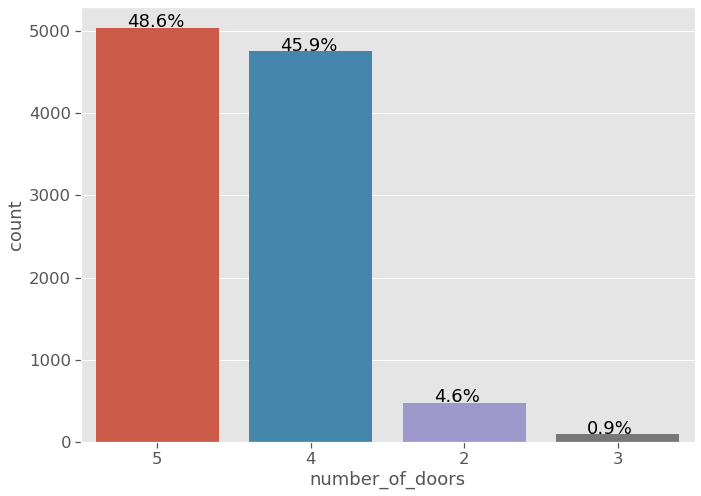

In [95]:
categorical_info("number_of_doors", train, rotate=0, x_shift_mult=1/4)

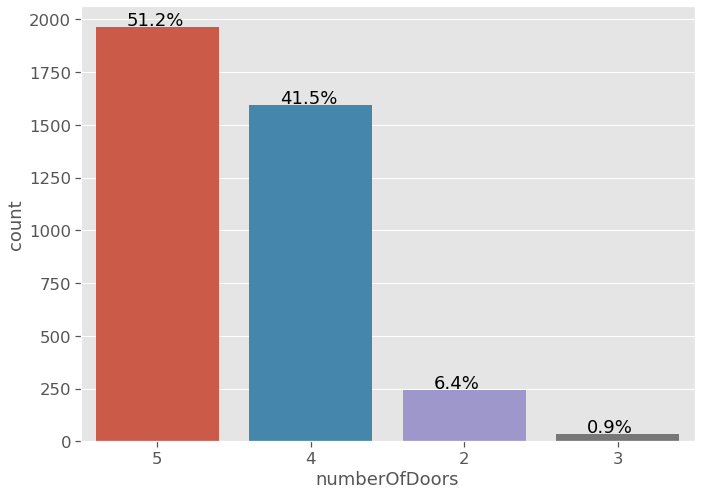

In [96]:
categorical_info("numberOfDoors", test, rotate=0, x_shift_mult=1/4)

Как видно, распределения выборок схожи, сделаем унификацию названий:

In [97]:
test.rename(columns={"numberOfDoors": "number_of_doors"}, inplace=True)

In [98]:
train.number_of_doors.dtype == test.number_of_doors.dtype

True

## productionDate (год производства автомобиля)

Приведем данные к типу int32 и посмотрим на распределения:

In [99]:
train.production_date = train.production_date.astype("int32")
test.productionDate = test.productionDate.astype("int32")

min    1976.000000
max    2020.000000
25%    2007.000000
50%    2012.000000
75%    2017.000000
std       7.625436
Name: production_date, dtype: float64


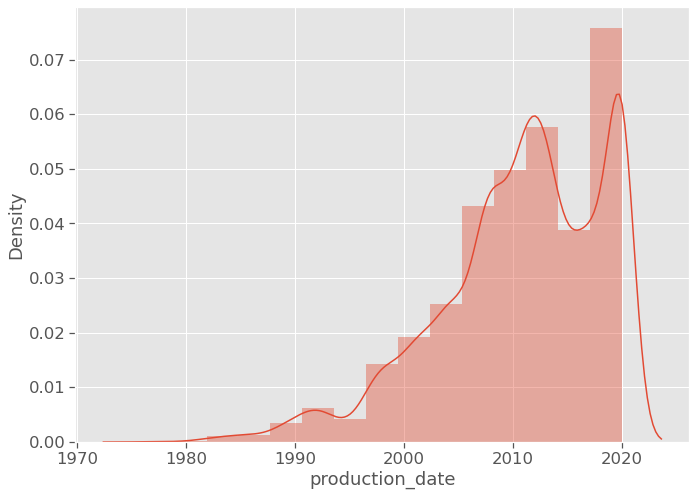

In [100]:
numeric_info(train.production_date, bins=15)

min    1981.000000
max    2019.000000
25%    2010.000000
50%    2013.000000
75%    2016.000000
std       5.186576
Name: productionDate, dtype: float64


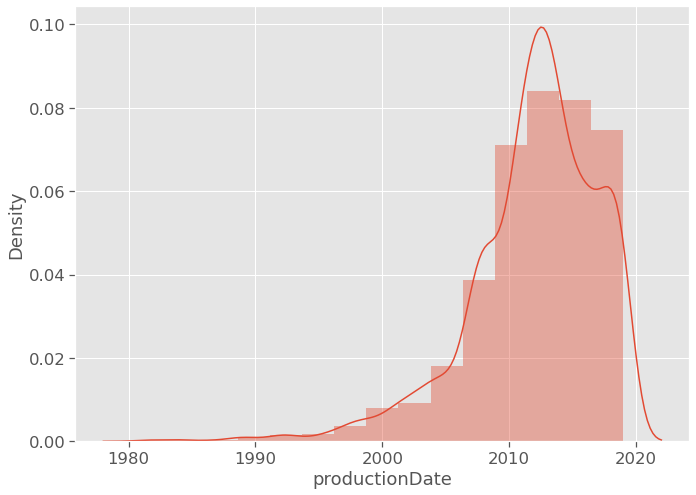

In [101]:
numeric_info(test.productionDate, bins=15)

Визуальный анализ показывает, что в тренировочном наборе есть пик для автомобилей 2020 года выпуска. Посмотрим на различия подробнее.

В тестовом наборе данных года выпуска автомобилей находятся в диапазоне от 1981 до 2019. В тренировочном наборе есть автомобили выходящие за эти рамки. 

Сделаем преобразование признака, получив новый, а именно: найдем возраст авто

In [102]:
train.production_date = 2020 - train.production_date
test.productionDate = 2020 - test.productionDate

In [103]:
test.rename(columns={"productionDate": "age"}, inplace=True)
train.rename(columns={"production_date": "age"}, inplace=True)

Посмотрим на распределения признака в обеих выборках после всех преобразований:

min     1.000000
max    39.000000
25%     4.000000
50%     7.000000
75%    10.000000
std     5.186576
Name: age, dtype: float64


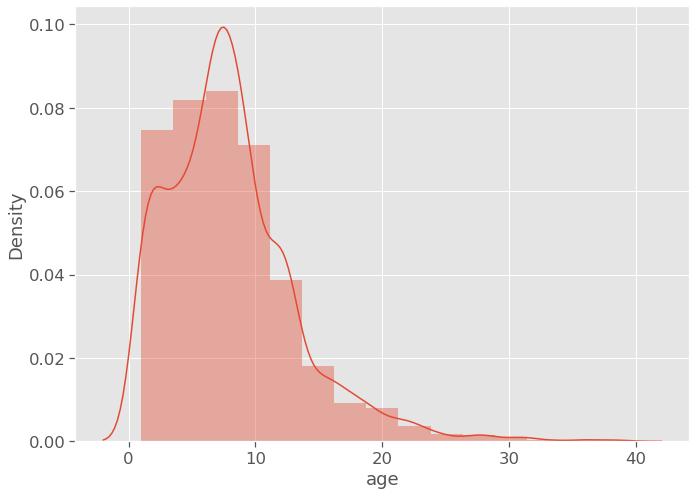

In [104]:
numeric_info(test.age, bins=15)

min     0.000000
max    44.000000
25%     3.000000
50%     8.000000
75%    13.000000
std     7.625436
Name: age, dtype: float64


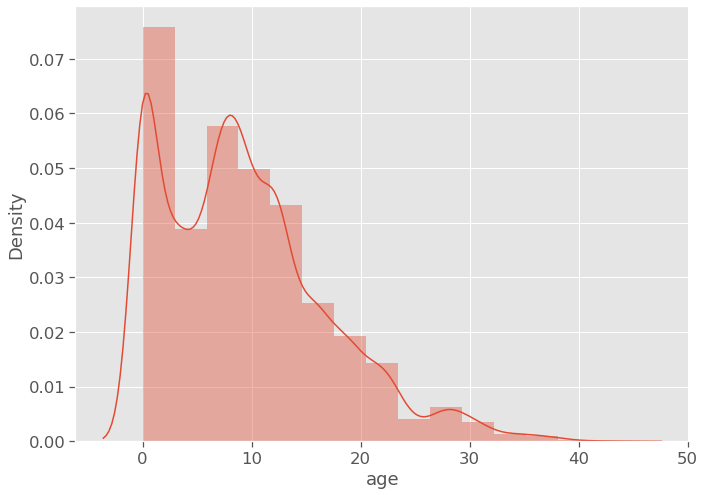

In [105]:
numeric_info(train.age, bins=15)

In [106]:
train=train[(train['age']>=1) & (train['age']<=39)]

## vehicleTransmission (тип трансмиссии)

Сделаем переименование признака и посмотрим на распределение:

In [107]:
trans_dict = {'AUTOMATIC': "автоматическая",
              'MECHANICAL': "механическая",
              'ROBOT': "роботизированная"
              }
train.vehicle_transmission = train.vehicle_transmission.map(trans_dict)

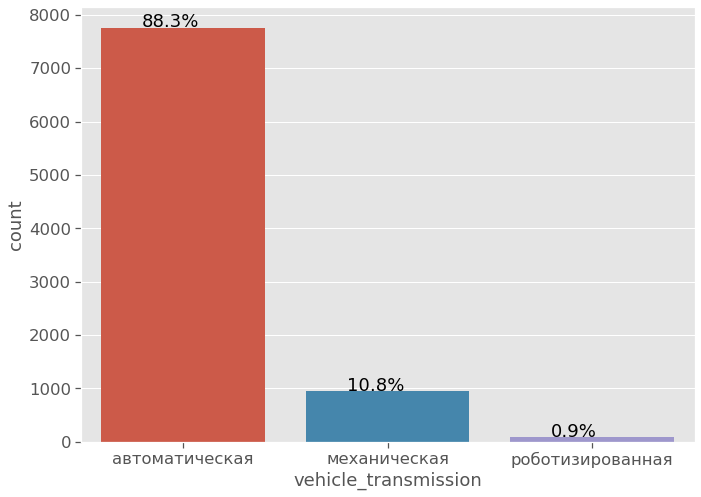

In [108]:
categorical_info("vehicle_transmission", train, rotate=0, x_shift_mult=1/4)

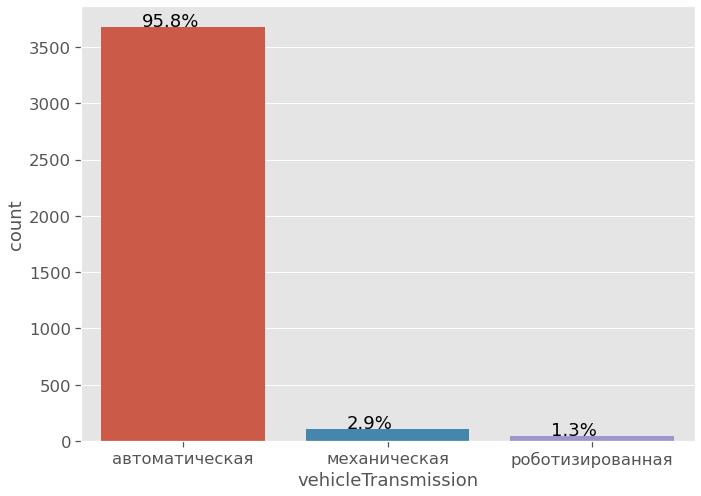

In [109]:
categorical_info("vehicleTransmission", test, rotate=0, x_shift_mult=1/4)

Как видно, в тренировочной выборке процент автомобилей с механической и роботизированной коробкой чуть выше. Сделаем унификацию:

In [110]:
test.rename(
    columns={"vehicleTransmission": "vehicle_transmission"}, inplace=True)

In [111]:
train.vehicle_transmission.dtype == test.vehicle_transmission.dtype

True

## engineDisplacement (объём двигателя)

Приведём данные к числовым и в train, и в test. Значения "undefined LTR" (электромобили) заменим на 0 (как в данных с сайта для тренировочной выборки)

In [112]:
test.engineDisplacement = test.engineDisplacement.apply(
    lambda x: float(x.split()[0]) if x.split()[0] != "undefined" else float(0))

In [113]:
train.engine_displacement = train.engine_displacement.map(
    lambda x: float(round(x/1000, 1)))

Распределения признака во многом похожи и имеют три пика для значений 2,3 и 4.5 литра. 

min    0.000000
max    6.600000
25%    2.000000
50%    2.500000
75%    3.000000
std    0.834614
Name: engine_displacement, dtype: float64


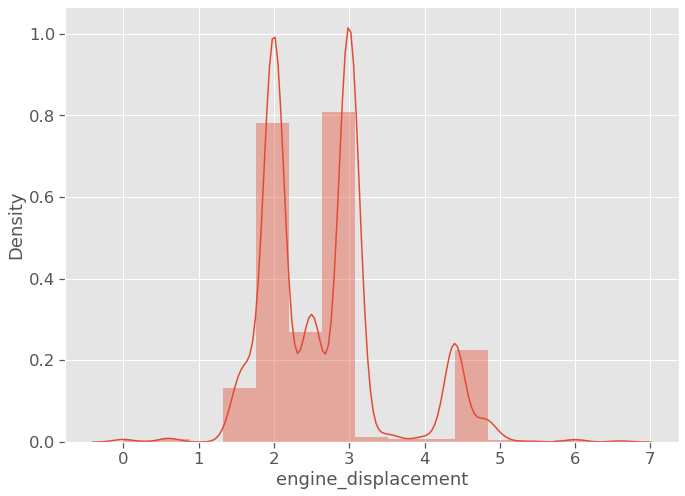

In [114]:
numeric_info(train.engine_displacement, bins=15)

min    0.000000
max    6.600000
25%    2.000000
50%    2.500000
75%    3.000000
std    0.819378
Name: engineDisplacement, dtype: float64


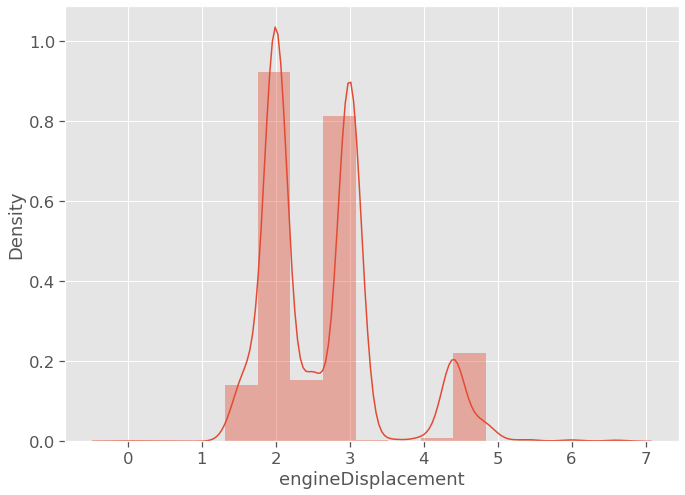

In [115]:
numeric_info(test.engineDisplacement, bins=15)

Анализ отличий показывает, что все виды объемов двигателей в тестовой выборке есть и в обучающей. Более того, в обучающей есть автомобили отличными объемами двигателя по сравнению с тестовой выборкой

In [116]:
difs = get_differences(train.engine_displacement, test.engineDisplacement)

Train - Test differences:

0.6    27
2.3     2
3.2     8
2.7     1
4.9     2
3.8     2
2.4    13
3.9     3
Name: engine_displacement, dtype: int64
Test - Train differences:

No differences


In [117]:
test.rename(
    columns={"engineDisplacement": "engine_displacement"}, inplace=True)

Посмотрим на количество автомобилей с электрическими двигателями:

In [118]:
len(train[train.engine_displacement == 0.0])

19

In [119]:
len(test[test.engine_displacement == 0.0])

1

In [120]:
train.engine_displacement.dtype == test.engine_displacement.dtype

True

## enginePower (мощность двигателя)

Приведем тестовые данные к числовому виду и посмотрим на распределения:

In [121]:
test.enginePower = test.enginePower.map(lambda x: int(x.split()[0]))

min     75.000000
max    625.000000
25%    177.000000
50%    218.000000
75%    272.000000
std     91.592941
Name: engine_power, dtype: float64


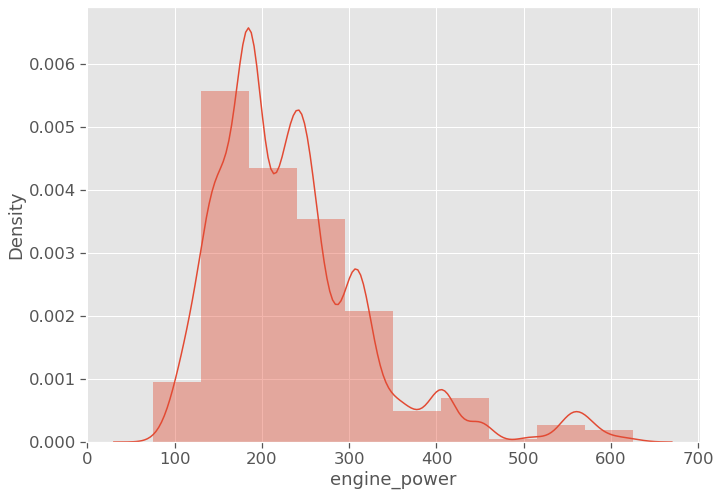

In [122]:
numeric_info(train.engine_power, bins=10)

min     90.000000
max    625.000000
25%    184.000000
50%    231.000000
75%    272.000000
std     91.429294
Name: enginePower, dtype: float64


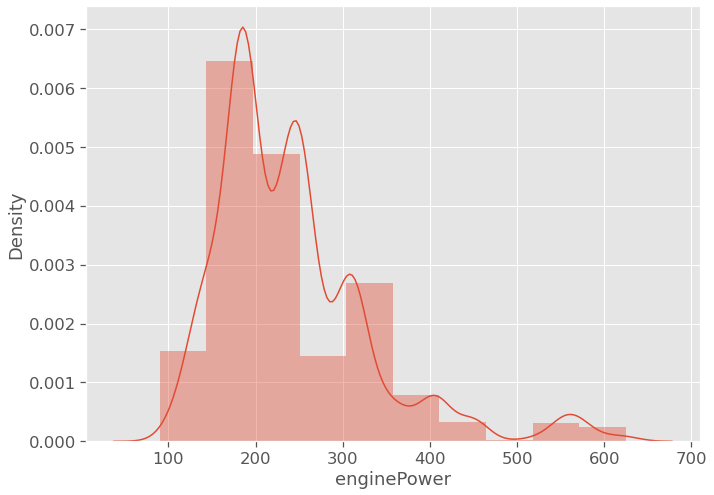

In [123]:
numeric_info(test.enginePower, bins=10)

Видно, что распределения схожи для обеих выборок, но посмотрим и на различия. Видим, что тестовый датасет содержит лишь небольшое количество автомобилей (3 шт.) с объемами двигателей, которых нет в тренировочной выборке. 

In [124]:
difs = get_differences(train.engine_power, test.enginePower)

Train - Test differences:

321     3
387     1
260     1
234     1
171     4
75      1
139     1
238     4
304     1
116    13
343     2
510     4
Name: engine_power, dtype: int64
Test - Train differences:

449    1
460    1
243    1
374    1
410    3
Name: enginePower, dtype: int64


In [125]:
test.rename(columns={"enginePower": "engine_power"}, inplace=True)

In [126]:
train.engine_power.dtype == test.engine_power.dtype

True

In [127]:
train=train[(train['engine_power']<=625) & (train['engine_power']>=90)]

## mileage (пробег)

Приведем данные к типу int32 и посмотрим на распределения:

In [128]:
train.mileage = train.mileage.astype("int32")
test.mileage = test.mileage.astype("int32")

min          0.000000
max    1000000.000000
25%      95000.000000
50%     156000.000000
75%     230000.000000
std     107712.814382
Name: mileage, dtype: float64


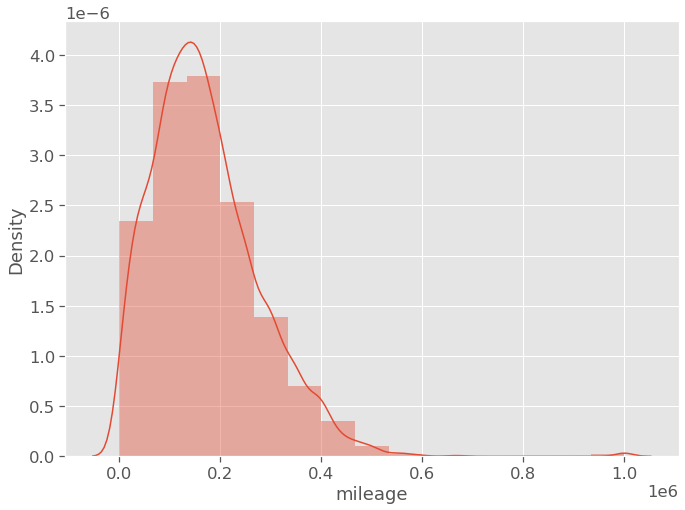

In [129]:
numeric_info(train.mileage, bins=15)

min          1.000000
max    1000000.000000
25%      58562.000000
50%     108000.000000
75%     160789.000000
std      85125.949826
Name: mileage, dtype: float64


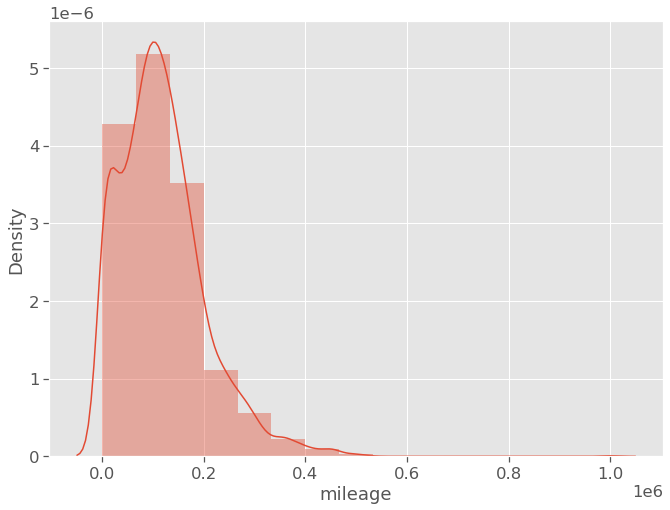

In [130]:
numeric_info(test.mileage, bins=15)

Видим, что распределния схожи за исключением лишь пика около 0 для новых автомобилей без пробега в тренировочной выборке

In [131]:
train.mileage.dtype == test.mileage.dtype

True

Добавим новый признак: разделим пробег на группы, исходя из того, что в среднем авто (данные Автостат) проходит за год 17000 км каждая группа будет грубо (не всегда пробег правдив) отображать количество лет эксплуатации. 

In [132]:
test["exp_year"] = test.mileage.apply(
    lambda x: x//17000 if x <= 400000 else 400000//17000+1)
train["exp_year"] = train.mileage.apply(
    lambda x: x//17000 if x <= 400000 else 400000//17000+1)

In [133]:
train=train[(train['mileage']>=1)]

## Комплектация

Займемся теперь парсингом комплектации автомобилей

In [134]:
import re

In [145]:
def get_features_train(complectation):      
    features=re.findall(r'\'(.+?)\'',complectation)
    return features

In [146]:
train['complectation'] = train['complectation'].apply(lambda x: get_features_train(x))

In [147]:
train.sample(5)

,body_type,brand,color,fuel_type,model_date_begin,model_date_end,name,model_name,number_of_doors,age,vehicle_transmission,engine_displacement,engine_power,mileage,complectation,gear_type,steering_wheel,not_damage,owners,pts_origin,custom_clear,price,exp_year
2247,hatchback3,BMW,black,petrol,30,2000,316i,3 серии,3,23,механическая,1.6,102,340000,[],REAR_DRIVE,LEFT,True,3.0,ORIGINAL,True,180000,20
7264,SUV,BMW,black,petrol,6,2017,20i,X3,5,5,автоматическая,2.0,184,108000,[],ALL_WHEEL_DRIVE,LEFT,True,2.0,ORIGINAL,True,1800000,6
1464,sedan,BMW,violet,petrol,19,2006,320i,3 серии,4,18,автоматическая,2.2,170,259410,"[cruise-control, engine-proof, airbag-driver, ...",REAR_DRIVE,LEFT,True,3.0,DUPLICATE,True,330000,15
3066,sedan,BMW,black,diesel,13,2010,520d,5 серии,4,11,автоматическая,2.0,163,275000,"[cruise-control, esp, airbag-driver, aux, usb,...",REAR_DRIVE,LEFT,True,2.0,ORIGINAL,True,800000,16
7234,SUV,BMW,white,petrol,10,2014,20i,X3,5,6,автоматическая,2.0,184,117000,"[cruise-control, esp, start-stop-function, eco...",ALL_WHEEL_DRIVE,LEFT,True,2.0,ORIGINAL,True,1400000,6


In [148]:
train_complectation = train.copy()

# Функция для отображения фич в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0
# Создаем набор фич
features = set()
for featurelist in train_complectation['complectation']:
    for feature in featurelist:
        features.add(feature)
# Cоздаем столбцы с фичами и заполняем 0 или 1
for item in features:
    train_complectation[item] = train_complectation['complectation'].apply(find_item)

In [149]:
cor_target = abs(train_complectation.corr()["price"])
relevant_features = cor_target[cor_target>0.3] # Выбираем фичи с значением модуля коэффициента корреляции > 0.3
relevant_features

model_date_begin                     0.647692
model_date_end                       0.668737
age                                  0.664776
engine_power                         0.437984
mileage                              0.617804
owners                               0.546874
price                                1.000000
exp_year                             0.643164
light-sensor                         0.376350
music-super                          0.383022
wheel-heat                           0.375968
led-lights                           0.506643
auto-mirrors                         0.335549
servo                                0.367297
body-kit                             0.316080
isofix                               0.353502
hcc                                  0.385043
start-button                         0.344179
steering-wheel-gear-shift-paddles    0.330764
front-seats-heat-vent                0.311331
glonass                              0.367865
keyless-entry                     

Создадим список значимых фич. Некоторые фичи не включаем т.к. не нашлось аналога в тестовой выборке.

In [150]:
complectation_list = [
    'bluetooth',
    'steering-wheel-gear-shift-paddles',
    'paint-metallic',
    'rain-sensor',
    'light-sensor',
    'isofix',
    'navigation',
    'multi-wheel',
    'usb',
    'airbag-curtain',
    'rear-camera',
    'body-kit',
    'front-seats-heat-vent',
    'power-latching-doors',
    'apple-carplay',
    'start-button',
    'auto-mirrors',
    'wireless-charger',
    'led-lights',
    'auto-park',
    'tyre-pressure',
    'high-beam-assist',
    '360-camera',
    'projection-display',
    'keyless-entry',
    'start-stop-function',
    'wheel-heat',
     'glonass',
    'adaptive-light',
    'electro-trunk'
]

Создадим словарь для замены фич в тестовой выборке

In [151]:
complectation_dict = {
    'Bluetooth': 'bluetooth',
    'Подрулевые лепестки переключения передач': 'steering-wheel-gear-shift-paddles',
    'Металлик': 'paint-metallic',
    'Датчик дождя': 'rain-sensor',
    'Датчик света': 'light-sensor',
    'Крепление детского кресла (передний ряд) ISOFIX': 'isofix',
    'Навигационная система': 'navigation',
    'Мультифункциональное рулевое колесо': 'multi-wheel',
    'USB': 'usb',
    'Подушки безопасности оконные (шторки)': 'airbag-curtain',
    'Камера задняя': 'rear-camera',
    'Обвес кузова': 'body-kit',
    'Вентиляция передних сидений': 'front-seats-heat-vent',
    'Доводчик дверей': 'power-latching-doors',
    'CarPlay': 'apple-carplay',
    'Запуск двигателя с кнопки': 'start-button',
    'Электроскладывание зеркал': 'auto-mirrors',
    'Беспроводная зарядка для смартфона': 'wireless-charger',
    'Светодиодные фары': 'led-lights',
    'Система автоматической парковки': 'auto-park',
    'Датчик давления в шинах': 'tyre-pressure',
    'Система управления дальним светом': 'high-beam-assist',
    'Камера 360°': '360-camera',
    'Проекционный дисплей': 'projection-display',
    'Система доступа без ключа': 'keyless-entry',
    'Система «старт-стоп»': 'start-stop-function',
    'Обогрев рулевого колеса': 'wheel-heat',
    'ЭРА-ГЛОНАСС': 'glonass',
    'Система адаптивного освещения': 'adaptive-light',
    'Электропривод крышки багажника': 'electro-trunk',
}

Заменим название значимых фич в тестовой выборке. Незначимые фичи оставим без изменений.

In [152]:
def test_feature_change(x):
    x = [complectation_dict.get(a) if complectation_dict.get(a) else a for a in x]
    return x

In [153]:
test['Комплектация'] = test['Комплектация'].apply(lambda x: test_feature_change(x))

Удалим из признака equipment все фичи кроме значимых для тестовой и тренировочной выборки.

In [156]:
def main_feature(x):
    super_features = []
    for equipment in x:
        if equipment in complectation_list:
            super_features.append(equipment)
    x = super_features
    return x

In [157]:
train['complectation'] = train['complectation'].apply(lambda x: main_feature(x))

In [158]:
test['Комплектация'] = test['Комплектация'].apply(lambda x: main_feature(x))

Создадим dummy-переменные для тестовой и тренировочной выборки

In [160]:
for item in complectation_list:
    train[item] = train['complectation'].apply(find_item)

In [162]:
for item in complectation_list:
    test[item] = test['Комплектация'].apply(find_item)

In [163]:
train.shape

(8775, 53)

In [164]:
test.shape

(3837, 54)

Таким образом мы получили dummy-переменные с наиболее коррелирующими с целевой переменной фичами автомобиля.

## Привод

Унифицируем названия признаков в выборках и посмотрим на распределения:

In [165]:
gear_dict = {'ALL_WHEEL_DRIVE': "полный",
             'REAR_DRIVE': "задний",
             'FORWARD_CONTROL': "передний"
             }
train.gear_type = train.gear_type.map(gear_dict)

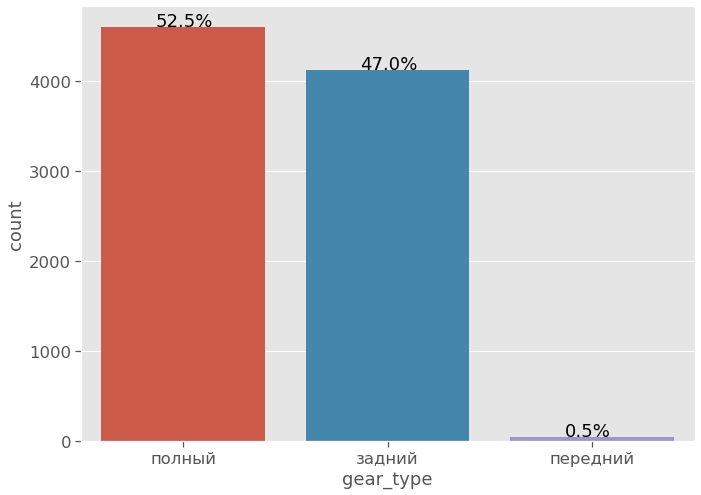

In [166]:
categorical_info("gear_type", train, rotate=0, x_shift_mult=1/3)

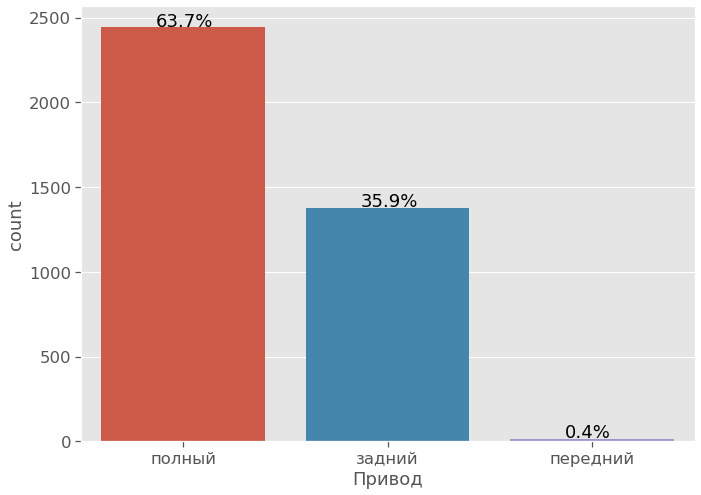

In [167]:
categorical_info("Привод", test, rotate=0, x_shift_mult=1/3)

Распределения признака в обеих выборках близки

In [168]:
test.rename(columns={"Привод": "gear_type"}, inplace=True)

In [169]:
gear_dict = {'полный': "full",
             'задний': "rear",
             'передний': "forward"
             }
train.gear_type = train.gear_type.map(gear_dict)
test.gear_type = test.gear_type.map(gear_dict)

In [170]:
train.gear_type.dtype == test.gear_type.dtype

True

## Руль 

In [171]:
if len(test["Руль"].unique()) == 1:
    print(
        f'Тестовый датасет полностью представлен автомобилями с типом руля {test["Руль"].unique()[0]}')

Тестовый датасет полностью представлен автомобилями с типом руля Левый


А в тренировочном есть небольшое количество праворульных авто, поэтому оставим этот признак. 

In [172]:
if len(train["steering_wheel"].unique()) == 1:
    print(
        f'Тестовый датасет полностью представлен автомобилями с типом руля {train["steering_wheel"].unique()[0]}')

In [173]:
test.rename(columns={"Руль": "steering_wheel"}, inplace=True)

In [174]:
wheel_dict = {'Левый': "LEFT"
              }
test.steering_wheel = test.steering_wheel.map(wheel_dict)

In [175]:
train.steering_wheel.dtype == test.steering_wheel.dtype

True

In [176]:
train[train['steering_wheel'] == 'RIGHT']

,body_type,brand,color,fuel_type,model_date_begin,model_date_end,name,model_name,number_of_doors,age,vehicle_transmission,engine_displacement,engine_power,mileage,complectation,gear_type,steering_wheel,not_damage,owners,pts_origin,custom_clear,price,exp_year,bluetooth,steering-wheel-gear-shift-paddles,paint-metallic,rain-sensor,light-sensor,isofix,navigation,multi-wheel,usb,airbag-curtain,rear-camera,body-kit,front-seats-heat-vent,power-latching-doors,apple-carplay,start-button,auto-mirrors,wireless-charger,led-lights,auto-park,tyre-pressure,high-beam-assist,360-camera,projection-display,keyless-entry,start-stop-function,wheel-heat,glonass,adaptive-light,electro-trunk
1641,coupe,BMW,dark_blue,petrol,22,2003,328i,3 серии,2,21,автоматическая,2.8,193,180000,"[usb, navigation, apple-carplay, bluetooth, au...",rear,RIGHT,True,3.0,DUPLICATE,True,385000,10,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5815,compactvan,BMW,dark_blue,diesel,5,2018,218d,2 серии Grand Tourer,5,4,автоматическая,2.0,150,43000,"[usb, multi-wheel, navigation, rear-camera, gl...",forward,RIGHT,True,1.0,ORIGINAL,True,1500000,2,1,0,0,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,1,0,1


## Состояние

In [177]:
print(
    f'Тестовый датасет полностью представлен автомобилями с состоянием: {test["Состояние"].unique()[0]}')

Тестовый датасет полностью представлен автомобилями с состоянием: Не требует ремонта


In [178]:
print(
    f'Тренировочный датасет полностью представлен автомобилями с состоянием not_damage: {train["not_damage"].unique()[0]}')

Тренировочный датасет полностью представлен автомобилями с состоянием not_damage: True


Как видно, все автомобили тренировочной выборки тоже не требуют ремонта, исключим признак из рассмотрения

In [179]:
test.rename(columns={"Состояние": "not_damage"}, inplace=True)

In [180]:
train.not_damage.dtype == test.not_damage.dtype

False

## Владельцы

У признака из обучающей выборки имеются пропуски:

In [181]:
print(round(100*(sum(train.owners.isna())/len(train)), 2), "%", sep="")

0.0%


In [182]:
owners_dict = {1.0: "one",
               2.0: "two",
               3.0: "three_more",
               np.nan: np.nan
               }
train.owners = train.owners.map(owners_dict)

Количество владельцев во многом зависит от возраста авто. Посмотрим на медианы возраста авто с пропущенными значениями количества владельцев:

In [183]:
for owners in list(train.owners.value_counts().index):
    print(owners, train[train.owners == owners].age.median())

three_more 13.0
two 8.0
one 4.0


Также посмотрим на конкретные значения возраста для пропусков:

In [184]:
train[train.owners.isna()].age.value_counts()

Series([], Name: age, dtype: int64)

Заменим пропуски по правилу: если старше 12 лет, то три и более владельцев, если моложе 10 и старше 6, то 2, иначе - 1

In [185]:
def is_missing(owner, year):

    if pd.isnull(owner):
        if year <= 6:
            return "one"
        elif year <= 10:
            return "two"
        else:
            return "three_more"
    else:
        return owner


train.owners = train.apply(lambda x: is_missing(x['owners'], x['age']), axis=1)

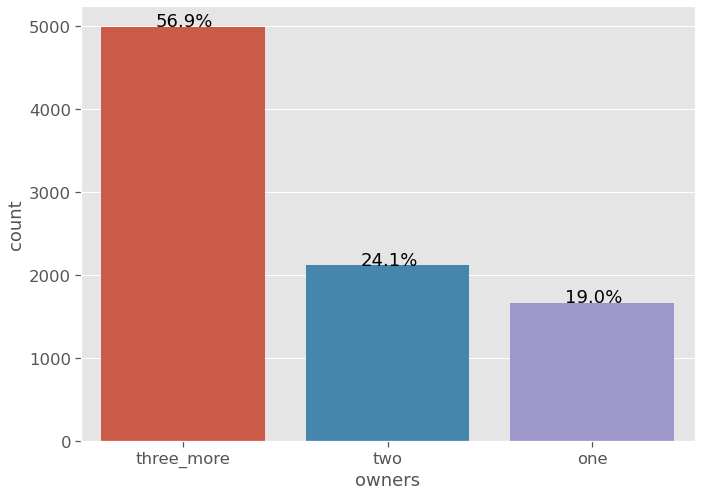

In [186]:
categorical_info("owners", train, rotate=0, x_shift_mult=1/3)

In [187]:
test.rename(columns={"Владельцы": "owners"}, inplace=True)

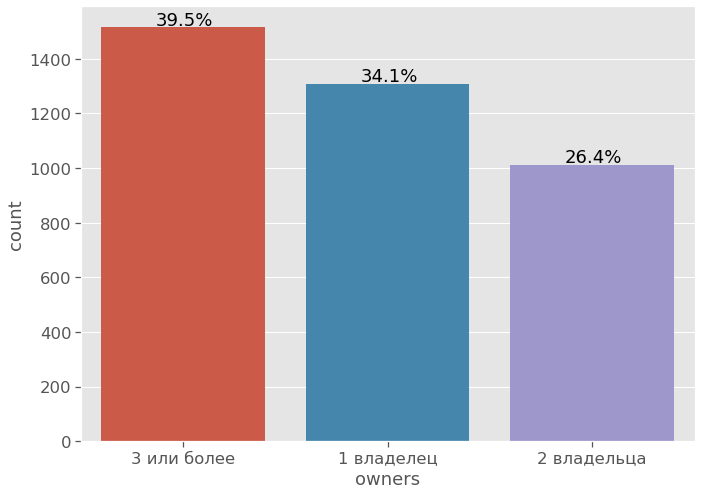

In [188]:
categorical_info("owners", test, rotate=0, x_shift_mult=1/3)

Сделаем унификацию названий признака:

In [189]:
owners_dict = {'1\xa0владелец': "one",
               '2\xa0владельца': "two",
               '3 или более': "three_more"
               }
test.owners = test.owners.map(owners_dict)

In [190]:
train.owners.dtype == test.owners.dtype

True

## ПТС

У признака из обучающей выборки имеются пропуски:

In [191]:
sum(train.pts_origin.isna())

1

In [192]:
print(round(100*(sum(train.pts_origin.isna())/len(train)), 2), "%", sep="")

0.01%


Заполним nan новой категорией 'unknown'

In [193]:
train.pts_origin.fillna("unknown", inplace=True)

In [194]:
pts_dict = {'ORIGINAL': "original",
            'DUPLICATE': "duplicate",
            "unknown": "unknown"
            }
train.pts_origin = train.pts_origin.map(pts_dict)

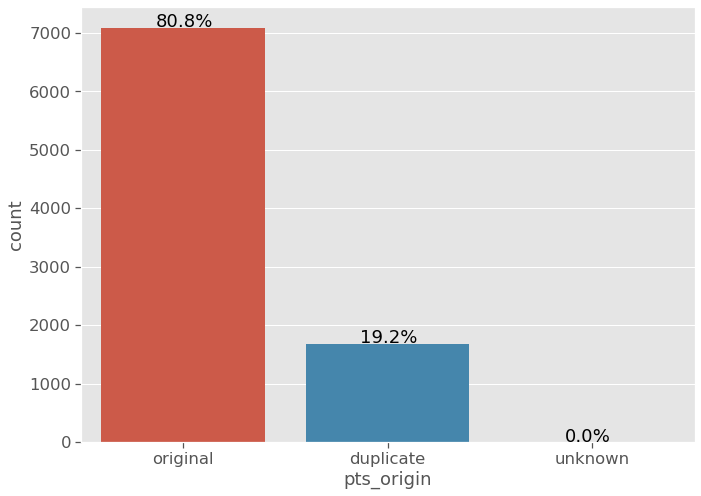

In [195]:
categorical_info("pts_origin", train, rotate=0, x_shift_mult=1/3)

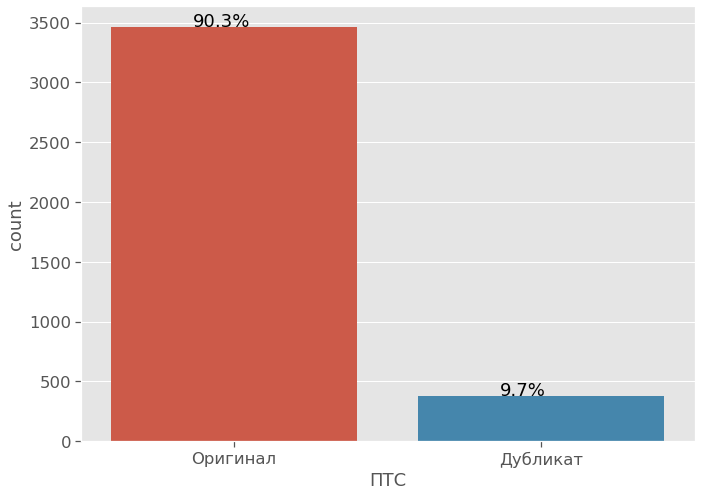

In [196]:
categorical_info("ПТС", test, rotate=0, x_shift_mult=1/3)

In [197]:
test.rename(columns={"ПТС": "pts_origin"}, inplace=True)

In [198]:
pts_dict = {'Оригинал': "original",
            'Дубликат': "duplicate"
            }
test.pts_origin = test.pts_origin.map(pts_dict)

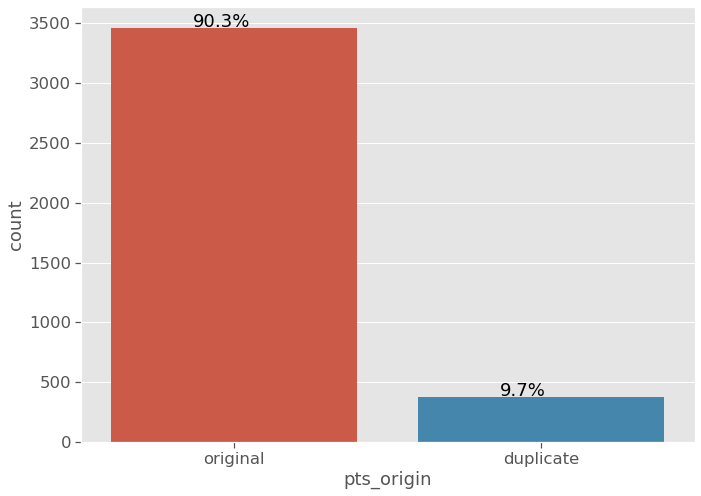

In [199]:
categorical_info("pts_origin", test, rotate=0, x_shift_mult=1/3)

In [200]:
train.pts_origin.dtype == test.pts_origin.dtype

True

## Таможня

In [201]:
print(
    f'Обучающий датасет полностью представлен автомобилями с состоянием таможня пройдена: {train["custom_clear"].unique()[0]}')

Обучающий датасет полностью представлен автомобилями с состоянием таможня пройдена: True


In [202]:
print(
    f'Тестовый датасет полностью представлен автомобилями с состоянием: {test["Таможня"].unique()[0]}')

Тестовый датасет полностью представлен автомобилями с состоянием: Растаможен


Удалим этот признак из-за отсутствия информативности для модели

## Цена

min    4.000000e+04
max    1.360000e+07
25%    5.500000e+05
50%    9.800000e+05
75%    1.650000e+06
std    1.231239e+06
Name: price, dtype: float64


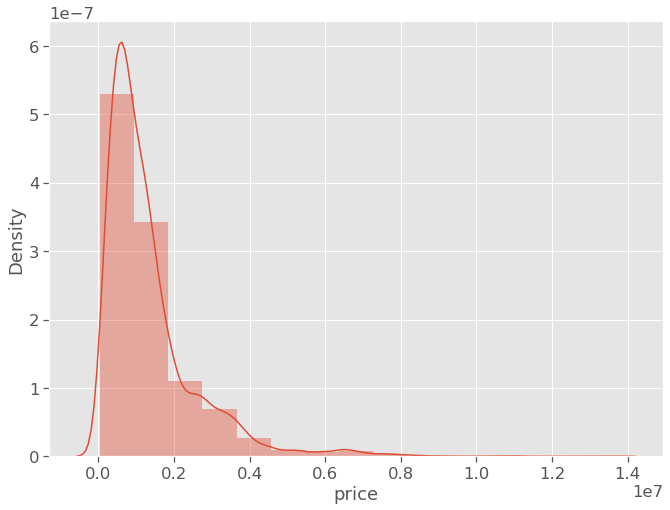

In [203]:
numeric_info(train.price, bins=15)

Цена имеет унимодальное распределение с длинным правом концом. Введем поправочный коэффициент цены, равный примерному отношению курса доллара для периода сбора данных тестового и тренировочного датасетов:

In [205]:
train=train[(train['price']<1.3e+07)]

Прологарифмируем признак price, чтобы сделать его похожим на нормальное распределение:

In [206]:
train['price'] = np.log(train["price"])

min    10.596635
max    16.223456
25%    13.217674
50%    13.795308
75%    14.316286
std     0.863941
Name: price, dtype: float64


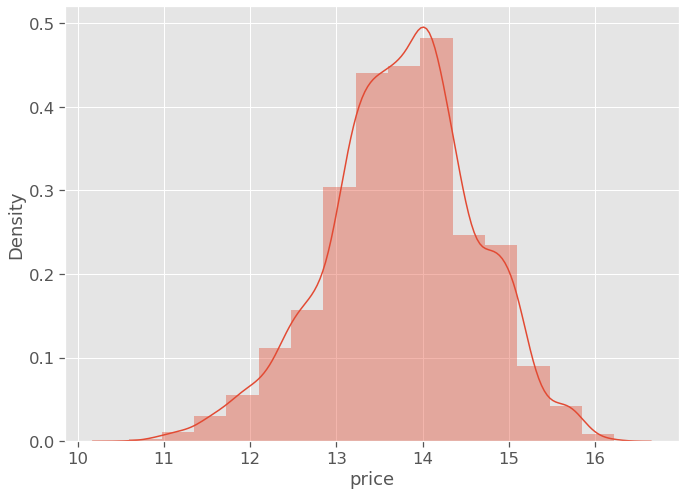

In [207]:
numeric_info(train.price, bins=15)

## Tax

Попробуем также добавить признак tax, означающий налог, взымаемый с владельца авто. Налог рассчитывается по формуле: 

Размер налога = Ставка налога * Налоговая база * (Количество месяцев владения/12) * Повышающий коэффициент.

Ставка налога варьируется от региона к региону. Возьмем ставку по городу Москва. Она варьируется от 12 до 150 руб/л.с. в зависимости от мощности двигателя. Налоговая база это мощность двигателя в л.с. Количество месяцев владения нам неизвестно, поэтому предположим, что ведем расчет для 12 месяцев. Повышающий коэффициент зависит от стоимости и возраста авто. К сожалению, его использовать не получится в виду отсутствия цены в тесте. Поэтому условно предположим, что он равен 1 для всех авто. Данные по ставкам и повышающему коэффициенту можно взять здесь: [коэффициент](https://nalog-nalog.ru/transportnyj_nalog/raschet_transportnogo_naloga/povyshayuwij_koefficient_dlya_transportnogo_naloga/) и [ставки](https://glavkniga.ru/situations/s509668)

In [208]:
def rate(power):
    if power > 250:
        return 150
    elif power > 225:
        return 75
    elif power > 200:
        return 65
    elif power > 175:
        return 50
    elif power > 150:
        return 45
    elif power > 125:
        return 35
    elif power > 100:
        return 25
    else:
        return 12

In [209]:
def calc_tax(row):
    return rate(row["engine_power"])*row["engine_power"]

In [210]:
train["tax"] = train.apply(lambda row: calc_tax(row), axis=1)
test["tax"] = test.apply(lambda row: calc_tax(row), axis=1)

min     1080.00000
max    93750.00000
25%     8850.00000
50%    14170.00000
75%    40800.00000
std    20389.79356
Name: tax, dtype: float64


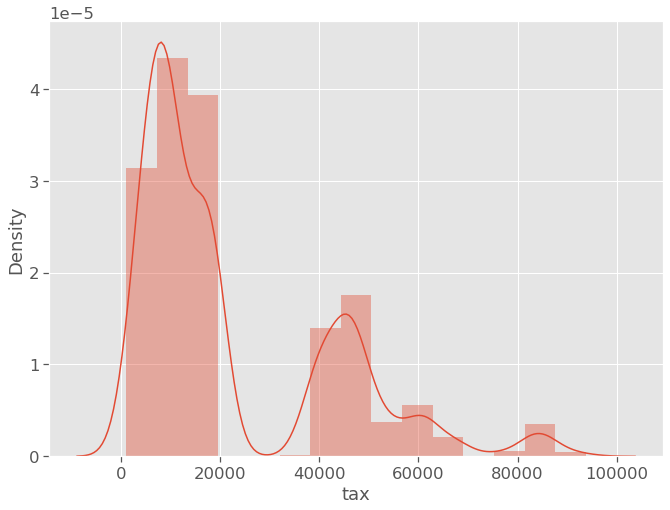

In [211]:
numeric_info(train.tax, bins=15)

## Сохранение данных

In [212]:
train.columns

Index(['body_type', 'brand', 'color', 'fuel_type', 'model_date_begin',
       'model_date_end', 'name', 'model_name', 'number_of_doors', 'age',
       'vehicle_transmission', 'engine_displacement', 'engine_power',
       'mileage', 'complectation', 'gear_type', 'steering_wheel', 'not_damage',
       'owners', 'pts_origin', 'custom_clear', 'price', 'exp_year',
       'bluetooth', 'steering-wheel-gear-shift-paddles', 'paint-metallic',
       'rain-sensor', 'light-sensor', 'isofix', 'navigation', 'multi-wheel',
       'usb', 'airbag-curtain', 'rear-camera', 'body-kit',
       'front-seats-heat-vent', 'power-latching-doors', 'apple-carplay',
       'start-button', 'auto-mirrors', 'wireless-charger', 'led-lights',
       'auto-park', 'tyre-pressure', 'high-beam-assist', '360-camera',
       'projection-display', 'keyless-entry', 'start-stop-function',
       'wheel-heat', 'glonass', 'adaptive-light', 'electro-trunk', 'tax'],
      dtype='object')

Уберём из данных все признаки, которые нужно убрать, исходя из проведенного анализа:

In [213]:
train.drop(['brand', 'model_date_end', 'model_name', 'complectation', 'steering_wheel',
            'not_damage', 'custom_clear'], axis=1, inplace=True)

In [214]:
test.columns

Index(['body_type', 'brand', 'color', 'fuel_type', 'model_date_begin', 'name',
       'number_of_doors', 'age', 'vehicleConfiguration',
       'vehicle_transmission', 'engine_displacement', 'engine_power',
       'description', 'mileage', 'Комплектация', 'gear_type', 'steering_wheel',
       'not_damage', 'owners', 'pts_origin', 'Таможня', 'Владение', 'id',
       'exp_year', 'bluetooth', 'steering-wheel-gear-shift-paddles',
       'paint-metallic', 'rain-sensor', 'light-sensor', 'isofix', 'navigation',
       'multi-wheel', 'usb', 'airbag-curtain', 'rear-camera', 'body-kit',
       'front-seats-heat-vent', 'power-latching-doors', 'apple-carplay',
       'start-button', 'auto-mirrors', 'wireless-charger', 'led-lights',
       'auto-park', 'tyre-pressure', 'high-beam-assist', '360-camera',
       'projection-display', 'keyless-entry', 'start-stop-function',
       'wheel-heat', 'glonass', 'adaptive-light', 'electro-trunk', 'tax'],
      dtype='object')

Уберём из данных все признаки, которые нужно убрать, исходя из проведенного анализа:

In [215]:
test.drop(['brand', 'vehicleConfiguration', 'description', 'Комплектация', 'steering_wheel',
           'not_damage', 'Таможня', 'Владение', 'id'], axis=1, inplace=True)

In [216]:
test.shape, train.shape

((3837, 46), (8774, 47))

Проверим идентичность имён столбцов:

In [217]:
sum(test.columns == train.drop("price", axis=1).columns)

46

Сохраним предобработанные данные:

In [218]:
train.to_csv("train_stack_tax.csv", index=False, header=True)

In [219]:
test.to_csv("test_stack_tax.csv", index=False, header=True)

# 4. Построение базовой модели

In [220]:
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

Как уже было сказано во введении, с точки зрения машинного обучения необходимо решить задачу **регрессии**. В нашем датасете присутствуют категориальные переменные и, вообще говоря, для многих регрессионных моделей необходимо сделать перевод этих переменных в числовые. Но для начала воспользуемся библиотекой **CatBoost** от Yandex, которая умеет работать с категориальными признаками. Для оценки качества предлагается использовать метрику MAPE. 

## CatBoostRegressor

Зададим настройки для расчёта: версию решения, воспроизводимость решения, число фолдов для кросс-валидации, размер тестовой выборки, а также число итераций и параметр скорости обучения для CatBoost (были подобраны в ручном режиме)

In [5]:
VERSION = 1
RANDOM_SEED = 42
N_FOLDS = 5
VAL_SIZE = 0.33

In [222]:
train = pd.read_csv('train_stack_tax.csv')
test = pd.read_csv('test_stack_tax.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [223]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8774 entries, 0 to 8773
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   body_type                          8774 non-null   object 
 1   color                              8774 non-null   object 
 2   fuel_type                          8774 non-null   object 
 3   model_date_begin                   8774 non-null   int64  
 4   name                               8774 non-null   object 
 5   number_of_doors                    8774 non-null   int64  
 6   age                                8774 non-null   int64  
 7   vehicle_transmission               8774 non-null   object 
 8   engine_displacement                8774 non-null   float64
 9   engine_power                       8774 non-null   int64  
 10  mileage                            8774 non-null   int64  
 11  gear_type                          8774 non-null   objec

In [224]:
numeric_idx = [3, 5, 6, 8, 9, 10, 14, 15, 46]
print(f'Числовые признаки:\n{list(train.columns[numeric_idx])}')

Числовые признаки:
['model_date_begin', 'number_of_doors', 'age', 'engine_displacement', 'engine_power', 'mileage', 'price', 'exp_year', 'tax']


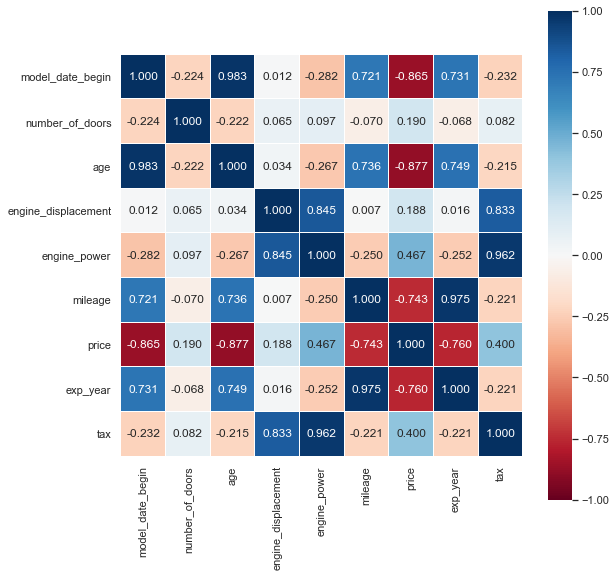

In [225]:
sns.set(font_scale=1)
plt.subplots(figsize=(9, 9))
sns.heatmap(train.iloc[:, numeric_idx].corr(), square=True,
            annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu", vmin=-1.0, vmax=1.0)

Из тепловой карты корреляций можно видеть, что есть признаки, у которых достаточно высокое значение корреляции: age и model_date_begin; exp_year и mileage; tax и engine_power. Проведенные эксперименты показали, что удаление признаков, которые порождают высокие значения корреляции не только не приводят к улучшению результата, но и ухудшают его, хоть и незначительно (1-2%).

Выделим тренировочные данные и целевую переменную:

In [226]:
X = train.drop(['price'], axis=1)
y = train.price.values

Сделаем разбиение на тренировочную и тестовую выборки:

In [227]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

Выделим категориальные признаки для CatBoost, в датасете это признаки с типом object, number_of_doors и все параметры комплектации авто:

In [228]:
cat_features_ids = np.where(X_train.dtypes == object)[0].tolist()

In [229]:
cat_features_ids.append(5)
cat_features_ids.append(14)

In [230]:
cat_features_ids.extend([i for i in range(15, 45)])

In [231]:
len(cat_features_ids)

40

In [232]:
X_train.columns[cat_features_ids]

Index(['body_type', 'color', 'fuel_type', 'name', 'vehicle_transmission',
       'gear_type', 'owners', 'pts_origin', 'number_of_doors', 'exp_year',
       'bluetooth', 'steering-wheel-gear-shift-paddles', 'paint-metallic',
       'rain-sensor', 'light-sensor', 'isofix', 'navigation', 'multi-wheel',
       'usb', 'airbag-curtain', 'rear-camera', 'body-kit',
       'front-seats-heat-vent', 'power-latching-doors', 'apple-carplay',
       'start-button', 'auto-mirrors', 'wireless-charger', 'led-lights',
       'auto-park', 'tyre-pressure', 'high-beam-assist', '360-camera',
       'projection-display', 'keyless-entry', 'start-stop-function',
       'wheel-heat', 'glonass', 'adaptive-light', 'electro-trunk'],
      dtype='object')

Запустим обучение: 

In [233]:
model = CatBoostRegressor(random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                          )
model.fit(X_train, y_train,
          cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          )

Learning rate set to 0.064398
0:	learn: 0.0471234	test: 0.0482274	best: 0.0482274 (0)	total: 297ms	remaining: 4m 56s
100:	learn: 0.0105545	test: 0.0116218	best: 0.0116218 (100)	total: 2.83s	remaining: 25.2s
200:	learn: 0.0096851	test: 0.0111727	best: 0.0111727 (200)	total: 5.5s	remaining: 21.8s
300:	learn: 0.0091538	test: 0.0109230	best: 0.0109230 (300)	total: 8.4s	remaining: 19.5s
400:	learn: 0.0086954	test: 0.0107801	best: 0.0107771 (398)	total: 11s	remaining: 16.4s
500:	learn: 0.0083841	test: 0.0107049	best: 0.0107042 (499)	total: 13.5s	remaining: 13.4s
600:	learn: 0.0080683	test: 0.0106706	best: 0.0106683 (592)	total: 16s	remaining: 10.6s
700:	learn: 0.0077936	test: 0.0106195	best: 0.0106195 (700)	total: 18.6s	remaining: 7.94s
800:	learn: 0.0075407	test: 0.0105867	best: 0.0105867 (800)	total: 21.3s	remaining: 5.3s
900:	learn: 0.0072998	test: 0.0105861	best: 0.0105772 (846)	total: 24.4s	remaining: 2.67s
999:	learn: 0.0071117	test: 0.0105910	best: 0.0105772 (846)	total: 26.7s	remaini

Сделаем предсказание и сохраним в файл:

In [234]:
predict_submission = np.exp(model.predict(test))
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1.963972e+06
1,1,2.423820e+06
2,2,1.293063e+06
3,3,2.787462e+06
4,4,5.299152e+06
5,5,2.152894e+06
6,6,1.135868e+06
7,7,7.354780e+05
8,8,1.550158e+06
9,9,1.531104e+06


Посмотрим на важность признаков с точки зрения модели, рассмотрим первые 20 и последние 10 признаков. Из первого распределения следует, что тройка самых значимых признаков такова: возраст авто, количество лет прошедших с начала выпуска модели,пробег. Кроме того можно видеть, что новый признак tax 5 по порядку значимости, а exp_year 11.

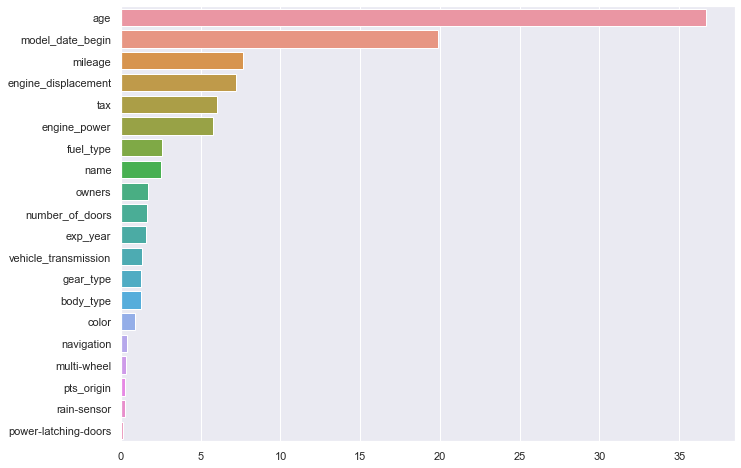

In [235]:
idx = np.flip(np.argsort(model.feature_importances_))
sns.barplot(x=model.feature_importances_[
            idx[:20]], y=np.array(model.feature_names_)[idx[:20]])

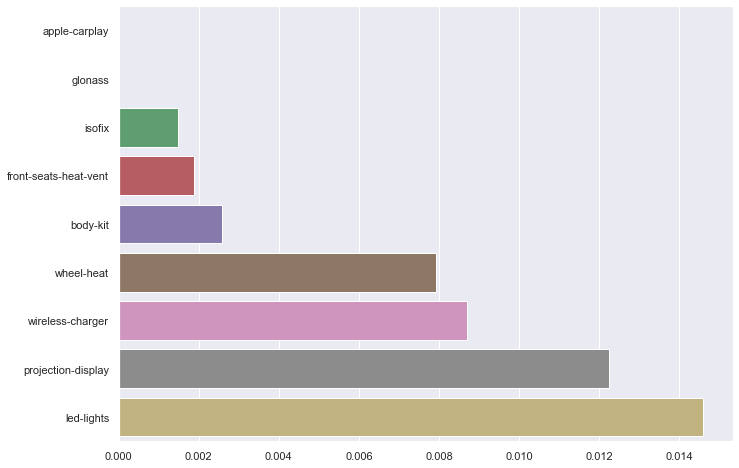

In [236]:
sns.barplot(x=model.feature_importances_[
            idx[:-10:-1]], y=np.array(model.feature_names_)[idx[:-10:-1]])

## Blending

Для того, чтобы избежать возможного переобучения и улучшить качество предсказания выполним обучение модели на 5 фолдах, с дальнейшим объединением предсказаний от каждой модели. 

In [237]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(random_seed=RANDOM_SEED,
                              eval_metric='MAPE')
    model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)

    return(model)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [238]:
submissions = pd.DataFrame(0, columns=["sub_1"], index=sample_submission.index)
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True,
                    random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # используем индексы, чтобы извлечь фолды на тренировочных и тестовых данных
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # модель для данного фолда
    model = cat_model(y_train, X_train, X_test, y_test,)
    # оценка модели на тесте
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # предсказанные значения
    submissions[f'sub_{idx+1}'] = np.exp(model.predict(test))
    model.save_model(f'catboost_fold_{idx+1}.model')

print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold Test MAPE: 0.011
2 Fold Test MAPE: 0.010
3 Fold Test MAPE: 0.010
4 Fold Test MAPE: 0.009
5 Fold Test MAPE: 0.009

Mean Score: 0.010
Std Score: 0.0005
Max Score: 0.011
Min Score: 0.009


Запишем полученный результат в файл:

In [239]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission.to_csv(f'submission_blend_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1.952051e+06
1,1,2.634801e+06
2,2,1.350300e+06
3,3,2.808939e+06
4,4,5.529973e+06
5,5,2.155569e+06
6,6,1.199110e+06
7,7,7.258595e+05
8,8,1.514529e+06
9,9,1.515847e+06


In [240]:
sample_submission['price'] = sample_submission['price'].apply(
    lambda x: x*0.86)
sample_submission.to_csv('submission_stacking.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1.678763e+06
1,1,2.265929e+06
2,2,1.161258e+06
3,3,2.415687e+06
4,4,4.755777e+06
5,5,1.853789e+06
6,6,1.031235e+06
7,7,6.242392e+05
8,8,1.302495e+06
9,9,1.303628e+06


In [241]:
sample_submission['price'] = sample_submission['price'].apply(
    lambda x: round(x/1000)*1000)
sample_submission.to_csv('submission_stacking.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1679000
1,1,2266000
2,2,1161000
3,3,2416000
4,4,4756000
5,5,1854000
6,6,1031000
7,7,624000
8,8,1302000
9,9,1304000


# 5. Стэкинг

In [250]:
from vecstack import stacking
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np

Используемые для стекинга модели, такие как RandomForestRegressor, ExtraTreesRegressor принимают на вход лишь числовые переменные и не умеют работать с категориальными, поэтому необходимо сделать преобразование категориальных признаков:

Прочитаем данные:

In [251]:
train = pd.read_csv('train_stack_tax.csv')
test = pd.read_csv('test_stack_tax.csv')

In [254]:
train.head(3)

,body_type,color,fuel_type,model_date_begin,name,number_of_doors,age,vehicle_transmission,engine_displacement,engine_power,mileage,gear_type,owners,pts_origin,price,exp_year,bluetooth,steering-wheel-gear-shift-paddles,paint-metallic,rain-sensor,light-sensor,isofix,navigation,multi-wheel,usb,airbag-curtain,rear-camera,body-kit,front-seats-heat-vent,power-latching-doors,apple-carplay,start-button,auto-mirrors,wireless-charger,led-lights,auto-park,tyre-pressure,high-beam-assist,360-camera,projection-display,keyless-entry,start-stop-function,wheel-heat,glonass,adaptive-light,electro-trunk,tax
0,hatchback5,brown,petrol,9,116i,5,7,автоматическая,1.6,136,94500,rear,one,original,13.514405,5,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4760
1,cabriolet,white,petrol,13,125i,2,12,автоматическая,3.0,218,135000,rear,three_more,duplicate,13.586097,7,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,14170
2,hatchback5,dark_blue,petrol,9,M135i,5,7,автоматическая,3.0,320,105000,full,three_more,duplicate,14.340239,6,1,1,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,1,0,48000


In [255]:
test.head(3)

,body_type,color,fuel_type,model_date_begin,name,number_of_doors,age,vehicle_transmission,engine_displacement,engine_power,mileage,gear_type,owners,pts_origin,exp_year,bluetooth,steering-wheel-gear-shift-paddles,paint-metallic,rain-sensor,light-sensor,isofix,navigation,multi-wheel,usb,airbag-curtain,rear-camera,body-kit,front-seats-heat-vent,power-latching-doors,apple-carplay,start-button,auto-mirrors,wireless-charger,led-lights,auto-park,tyre-pressure,high-beam-assist,360-camera,projection-display,keyless-entry,start-stop-function,wheel-heat,glonass,adaptive-light,electro-trunk,tax
0,sedan,black,diesel,4,520d,4,3,автоматическая,2.0,190,158836,rear,one,original,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9500
1,sedan,white,diesel,2,318d,4,1,автоматическая,2.0,150,10,rear,one,original,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5250
2,sedan,dark_blue,petrol,11,550i,4,8,автоматическая,4.4,407,120000,full,two,original,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61050


Выделим категориальные признаки:

In [256]:
cat_features_ids = np.where(train.dtypes == object)[0].tolist()
cat_features_ids.append(5)
cat_features_ids.append(15)
#cat_features_ids.extend([i for i in range(16, 46)])
categorical_features_names = list(train.columns[cat_features_ids])

In [257]:
categorical_features_names

['body_type',
 'color',
 'fuel_type',
 'name',
 'vehicle_transmission',
 'gear_type',
 'owners',
 'pts_origin',
 'number_of_doors',
 'exp_year']

Объединим тренировочный и тестовый датасеты для dummy-кодирования, добавив столбец price = 0 в тестовую выборку и столбец sample = {0,1} в обе выборки для их разделения в дальнейшем:

In [258]:
train['sample'] = 1
test['sample'] = 0
test['price'] = 0
data = test.append(train, sort=False).reset_index(drop=True)

In [259]:
train.shape, test.shape, data.shape

((8774, 48), (3837, 48), (12611, 48))

Сделаем dummy-кодирование для всех категориальных переменных:

In [260]:
for column in categorical_features_names:
    dummies_train = pd.get_dummies(data[column], prefix=data[column].name)
    data = data.drop(data[column].name, axis=1).join(dummies_train)

In [261]:
data.shape

(12611, 284)

Сделаем разделение на тренировочную и тестовую выборки, а также удалим столбцы sample из обеих выборок и фиктивный столбец price из тестовой: 

In [262]:
train = data[data["sample"] == 1]
test = data[data["sample"] == 0]
train.drop(columns=["sample"], inplace=True)
test.drop(columns=["sample", "price"], inplace=True)

In [263]:
train.shape, test.shape

((8774, 283), (3837, 282))

Сохраним полученные датасеты для дальнейшего использования:

In [264]:
train.to_csv('train_numeric_tax.csv', index=False)
test.to_csv('test_numeric_tax.csv', index=False)

## Подбор гиперпараметров для каждой модели 

В стекинге будем использовать следующие модели: 

1. RandomForestRegressor

2. ExtraTreesRegressor

3. CatBoostRegressor

4. LinearRegression

Первые три модели будут представлять первый уровень, а линейная регрессия будет моделью второго уровня. Нами была рассмотрена также модель KNeighborsRegressor, но её использование в стекинге не дало улучшения. Перед тем как запускать процедуру стекинга, необходимо оптимизировать каждую из моделей, то есть подобрать гиперпараметры. Гиперпараметры для CatBoost были подобраны ранее, для линейной регрессии гиперпараметры подбираться не будут. 

Загрузим данные:

In [267]:
train = pd.read_csv('train_numeric_tax.csv')
test = pd.read_csv('test_numeric_tax.csv')
y = train.price.values
X_train = train.drop(['price'], axis=1)
X_test = test
X_train.shape, X_test.shape, y.shape

((8774, 282), (3837, 282), (8774,))

Проведем подбор параметров для модели RandomForestRegressor. Для этого специальным образом определим функцию скоринга mape, так как её нет среди стандартных функций. Из параметров будем определять количество деревьев, их глубину и нужен ли bootstrap для выборки. Эта часть кода запускалась на Kaggle, так как вычисления ресурсоемки, поэтому просто приведём результаты его работы

In [268]:
# def mape(y_true, y_pred):
#     return -np.mean(np.abs((y_pred-y_true)/y_true))


# score = make_scorer(mape)

# param_grid = [
#     {'n_estimators': [100, 500, 1000],
#      'max_depth': [10, 50, None], 'bootstrap': [True, False]}
# ]

# grid_search_forest = GridSearchCV(RandomForestRegressor(
#     n_jobs=-1), param_grid, cv=3, scoring=score, verbose=2)
# grid_search_forest.fit(X_train, y)
# grid_search_forest.best_params_

Оптимальные параметры: n_estimators = 1000, max_depth = None, bootstrap = True

Аналогичную операцию подбора проведём для ExtraTreesRegressor:

In [269]:
# param_grid = [
#     {'n_estimators': [100, 500, 1000],
#      'max_depth': [10, 50, None], 'bootstrap': [True, False]}
# ]

# grid_search_extra = GridSearchCV(ExtraTreesRegressor(
#     n_jobs=-1), param_grid, cv=3, scoring=score, verbose=2)
# grid_search_extra.fit(X_train, y)
# grid_search_extra.best_params_

Оптимальные параметры: n_estimators = 1000, max_depth = None, bootstrap = True

In [270]:
# def mape(y_true, y_pred):
#     return -np.mean(np.abs((y_pred-y_true)/y_true))

# score = make_scorer(mape)

# param_grid = [
#     {'depth': [6,8,10], 'learning_rate': [0.01, 0.05, 0.1], 'iterations': [1500, 2000, 2500]}
# ]

# grid_search_cat = GridSearchCV(CatBoostRegressor(), param_grid, cv=3, scoring=score, verbose=2)
# grid_search_cat.fit(X_train, y)
# grid_search_cat.best_params_

## Стекинг

Теперь всё готово для проведения стекинга. Воспользуемся для этого библиотекой **stacking**, которая была рекомендована в baseline. Вычисления также проводились на платформе Kaggle. 

In [271]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


# Определим конфигурацию моделей
RANDOM_SEED = 42

lr = LinearRegression(normalize=True, n_jobs=-1)

etc = ExtraTreesRegressor(n_estimators = 1000, max_depth = None, bootstrap = True, random_state=RANDOM_SEED, n_jobs=-1)
catb = CatBoostRegressor(random_seed=RANDOM_SEED, eval_metric='MAPE', verbose=1000)
rf = RandomForestRegressor(n_estimators = 1000, max_depth = None, bootstrap = True, random_state=RANDOM_SEED, n_jobs=-1)

# Инициализируем модели 1-го уровня
models = [rf, etc, catb]

# Вычислим признаки для передачи в мета-модель
S_train, S_test = stacking(models, X_train, y, X_test,
                           regression=True, metric=mape, n_folds=4,
                           shuffle=True, random_state=RANDOM_SEED, verbose=2)

# Инициализируем модель 2 уровня (мета-модель)
model = lr

# Обучим
model = model.fit(S_train, y)

# Сделаем предсказание и запишем в файл (округление цены до тысяч приводит к незначительному улучшению качества)
y_test_pred = np.exp(model.predict(S_test))
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['price'] = y_test_pred

task:         [regression]
metric:       [mape]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestRegressor]
    fold  0:  [0.01068928]
    fold  1:  [0.01057064]
    fold  2:  [0.01002727]
    fold  3:  [0.01006199]
    ----
    MEAN:     [0.01033730] + [0.00029591]
    FULL:     [0.01033736]

model  1:     [ExtraTreesRegressor]
    fold  0:  [0.01050916]
    fold  1:  [0.01049224]
    fold  2:  [0.00977256]
    fold  3:  [0.00993878]
    ----
    MEAN:     [0.01017818] + [0.00032788]
    FULL:     [0.01017826]

model  2:     [CatBoostRegressor]
Learning rate set to 0.054581
0:	learn: 0.0476468	total: 241ms	remaining: 4m
999:	learn: 0.0078998	total: 5.48s	remaining: 0us
    fold  0:  [0.01028641]
Learning rate set to 0.054581
0:	learn: 0.0479217	total: 5.44ms	remaining: 5.44s
999:	learn: 0.0079929	total: 6.61s	remaining: 0us
    fold  1:  [0.01042542]
Learning rate set to 0.054583
0:	learn: 0.0474696	total: 21.5ms	remaining: 21.5s
999:	learn: 0.0080456	total: 

In [272]:
sample_submission['price'] = sample_submission['price'].apply(lambda x: x*0.86)
sample_submission.to_csv('submission_stacking.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1.706441e+06
1,1,2.193147e+06
2,2,1.168553e+06
3,3,2.412772e+06
4,4,4.710081e+06
5,5,1.909086e+06
6,6,1.019453e+06
7,7,6.204680e+05
8,8,1.315342e+06
9,9,1.302191e+06


In [273]:
sample_submission['price'] = sample_submission['price'].apply(
    lambda x: round(x/1000)*1000)
sample_submission.to_csv('submission_stacking.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1706000
1,1,2193000
2,2,1169000
3,3,2413000
4,4,4710000
5,5,1909000
6,6,1019000
7,7,620000
8,8,1315000
9,9,1302000


# 6. AutoML

Испробуем BestSingleModelRegressor

In [2]:
import pandas as pd
import numpy as np

# from automl_alex import BestSingleModelRegressor

import jdk

import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from C:\Users\Stanislav\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\STANIS~1\AppData\Local\Temp\tmpngjmjrhm
  JVM stdout: C:\Users\STANIS~1\AppData\Local\Temp\tmpngjmjrhm\h2o_Stanislav_started_from_python.out
  JVM stderr: C:\Users\STANIS~1\AppData\Local\Temp\tmpngjmjrhm\h2o_Stanislav_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,11 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_Stanislav_tisme9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,884 Mb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [3]:
train = pd.read_csv('train_numeric_tax.csv')
test = pd.read_csv('test_numeric_tax.csv')
y = train.price.values
X_train = train.drop(['price'], axis=1)
X_test = test
X_train.shape, X_test.shape, y.shape

((8774, 282), (3837, 282), (8774,))

In [6]:
#X_train, X_test, y_train = X_train, X_test, y

In [7]:
#model = BestSingleModelRegressor(X_train, y_train, X_test, random_state = RANDOM_SEED, verbose = 1)

In [8]:
# history = model.opt(timeout=1000, verbose=1)

In [9]:
# model.history_trials_dataframe.head(5)

In [10]:
# predicts = model.predict()
# predicts.head(5)

In [11]:
# len(predicts['predict_test'][0])

In [12]:
# predict_submission[0][1]

In [13]:
# sample_submission['price'] = predict_submission[0][1]
# sample_submission['price'] = sample_submission['price'].apply(lambda x: np.exp(x))
# sample_submission['price'] = sample_submission['price'].apply(lambda x: x*0.86)
# sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x/1000)*1000)
# sample_submission.to_csv(f'AutoML.csv', index=False)

Испробуем H2OAutoML

In [14]:
training_frame  = h2o.H2OFrame(train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [15]:
test_frame = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [16]:
y = 'price'

In [17]:
aml = H2OAutoML(max_runtime_secs = 600, seed = RANDOM_SEED, project_name = "rds_03")
aml.train(y=y, training_frame=training_frame)

AutoML progress: |
19:10:14.213: AutoML: XGBoost is not available; skipping it.

█████████████████
19:12:35.718: XRT_1_AutoML_20201020_191014 [DRF XRT (Extremely Randomized Trees)] failed: java.lang.AssertionError

███████████████████████████████████████| 100%


In [18]:
aml.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid__1_AutoML_20201020_191014_model_2,0.047279,0.217437,0.047279,0.138232,0.0155113
GBM_3_AutoML_20201020_191014,0.0474865,0.217914,0.0474865,0.138144,0.015525
GBM_2_AutoML_20201020_191014,0.0479597,0.218997,0.0479597,0.137608,0.0156054
GBM_grid__1_AutoML_20201020_191014_model_4,0.0479731,0.219028,0.0479731,0.138523,0.015592
GBM_1_AutoML_20201020_191014,0.0490856,0.221553,0.0490856,0.140592,0.0157921
GBM_grid__1_AutoML_20201020_191014_model_3,0.0492605,0.221947,0.0492605,0.138094,0.0158244
GBM_4_AutoML_20201020_191014,0.0509255,0.225667,0.0509255,0.144971,0.0160532
GBM_grid__1_AutoML_20201020_191014_model_1,0.0516164,0.227193,0.0516164,0.143011,0.0162089
DRF_1_AutoML_20201020_191014,0.0534384,0.231167,0.0534384,0.146934,0.016455
GBM_5_AutoML_20201020_191014,0.0565814,0.237868,0.0565814,0.154275,0.0168014


In [19]:
predicts = aml.predict(test_frame)
predicts.head(5)

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict
13.7476
14.5271
14.5911
14.1703
14.7769


In [20]:
type(predicts)

h2o.frame.H2OFrame

In [21]:
predict_submission = np.array(h2o.as_list(predicts))

In [24]:
predict_submission = np.delete(predict_submission, 0)

In [25]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['price'] = predict_submission
sample_submission['price'] = sample_submission['price'].apply(lambda x: np.exp(x))
sample_submission['price'] = sample_submission['price'].apply(lambda x: x*0.86) # коэффициент подобран опытным путем
sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x/1000)*1000)
sample_submission.to_csv(f'AutoML.csv', index=False)

### Финальные результаты

Применение AutoML позволило улучшить результат модели до **8.79**, что, несомненно, является улучшением модели. 